# Data exploration

In this notebook, we review the dataset to understand what the data represent and the relationship between data elements. This also includes dealing with the null values and defining the preprocessing function.


## Import statements

In [1314]:
pip install --upgrade seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1315]:
pip install prettytable

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1517]:
# Import statements 
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.preprocessing import LabelEncoder

### 1° Loading the dataset

In [1317]:
filepath = '../../RFQ_Data_Challenge_HEC.csv'
df = pd.read_csv(filepath)
df.head()

/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_71306/1895652701.py:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


,Deal_Date,ISIN,cusip,Instrument,Sales_Name,Sales_Initial,company_short_name,B_Price,B_Side,Total_Requested_Volume,...,MidYTM,YTWDate,SpreadvsBenchmarkMid,MidASWSpread,MidZSpread,GSpreadMid,MidModifiedDuration,MidConvexity,MidEffectiveDuration,MidEffectiveConvexity
0,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Bnp Reunion,0.0,NATIXIS SELL,77551,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
1,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Cegi Ett,0.0,NATIXIS SELL,8163,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
2,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Qbe,0.0,NATIXIS SELL,20408,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
3,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 2.5% 25 FEB 2025,Blanca Tailpied,BLA,Cegi Ett,0.0,NATIXIS SELL,16327,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
4,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 2.5% 25 FEB 2025,Constantin Durie,CON,Scp Laureau-Jeannerot,0.0,NATIXIS SELL,244898,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874


## 2° Defining the preprocessing function

Looking at null values : 

In [1320]:
# Null values analysis for columns with null values below 15000
below_threshold = df.isnull().sum().sort_values(ascending=False) < 15000
print("Columns with null values below 15000:")
print(below_threshold[below_threshold].index)

# Null values analysis for columns with null values above 15000
above_threshold = df.isnull().sum().sort_values(ascending=False) >= 15000
print("\nColumns with null values above or equal to 15000:")
print(above_threshold[above_threshold].index)

Columns with null values below 15000:
Index(['Sales_Initial', 'Sales_Name', 'MidYTM', 'Coupon', 'Ccy',
       'BloomIndustryGroup', 'BloomIndustrySector', 'Instrument', 'cusip',
       'maturity', 'cdcissuerShortName', 'Frequency', 'MidPrice', 'cdcissuer',
       'company_short_name', 'BloomIndustrySubGroup', 'B_Price',
       'Classification', 'Total_Traded_Volume_Natixis', 'B_Side',
       'Total_Traded_Volume_Away', 'Total_Requested_Volume',
       'Total_Traded_Volume', 'Type', 'Maturity', 'ISIN', 'Deal_Date'],
      dtype='object')

Columns with null values above or equal to 15000:
Index(['Tier', 'AssumedMaturity', 'YTWDate', 'GSpreadMid',
       'SpreadvsBenchmarkMid', 'Cusip', 'MidEffectiveConvexity',
       'MidEffectiveDuration', 'MidASWSpread', 'Rating_Moodys', 'MidConvexity',
       'Rating_Fitch', 'MidZSpread', 'Rating_SP', 'MidModifiedDuration',
       'Country', 'lb_Platform_2'],
      dtype='object')


In [1322]:
df.isnull().sum().sort_values(ascending=False)


Tier                           627099
AssumedMaturity                599993
YTWDate                        507919
GSpreadMid                     333967
SpreadvsBenchmarkMid           273311
Cusip                          165543
MidEffectiveConvexity           75153
MidEffectiveDuration            75118
MidASWSpread                    68284
Rating_Moodys                   60762
MidConvexity                    51382
Rating_Fitch                    43273
MidZSpread                      42737
Rating_SP                       41452
MidModifiedDuration             37265
Country                         22434
lb_Platform_2                   22434
Sales_Initial                   13876
Sales_Name                      13868
MidYTM                          13045
Coupon                           8545
Ccy                              1948
BloomIndustryGroup               1037
BloomIndustrySector              1037
Instrument                        998
cusip                             319
maturity    

And column's types :

In [1321]:
df.dtypes

Deal_Date                       object
ISIN                            object
cusip                           object
Instrument                      object
Sales_Name                      object
Sales_Initial                   object
company_short_name              object
B_Price                         object
B_Side                          object
Total_Requested_Volume          object
Total_Traded_Volume_Natixis    float64
Total_Traded_Volume_Away       float64
Total_Traded_Volume            float64
BloomIndustrySector             object
BloomIndustryGroup              object
BloomIndustrySubGroup           object
cdcissuerShortName              object
cdcissuer                       object
Country                         object
lb_Platform_2                   object
maturity                        object
Rating_Fitch                    object
Rating_Moodys                   object
Rating_SP                       object
Cusip                           object
Ccy                      

First insights on features :
- **Deal_Date** : The date on which a financial deal is executed. Needs to be converteted in datetime.
- **ISIN** : International Securities Identification Number, a unique identifier for Financial instruments.
- **company_short_name** : the name of the issuer of the financial instrument. It corresponds to the client name.
- **B_price** : The bid price of the financial instrument. To be converted to int (object for the moment)
- **B_side** : Natixis's position as a buyer or seller of the financial instrument (for the moment 'NATIXIS SELL' or 'NATIXIS BUY'). Contient 8 valeurs nulles.
- **Total_Requested_Volume** : The requested volume for buying or selling the financial instrument. It needs to be converted into a numerical column (object for the moment). Contient 2 valeurs nulles.
- **Total_Traded_Volume_Natixis** : The volume of the financial instrument traded by Natixis. Already good data type.
- **Total_Traded_Volume_Away** : The volume of the financial instrument traded by other banks. Already good data type.
- **Total_Traded_Volume** : The total volume of the financial instrument traded. Already good data type.
- **BloomIndustrySector**, **BloomIndustryGroup**,**BloomIndustrySubGroup**
- **maturity** : The length of time during which interest is paid. Some null values are marked as NaT. We convert this column into Datetime type. Some maturities go back to 1900, it is not possible. We delete those.
- **Rating_Fitch** : The credit rating of the financial instrument from Fitch Ratings.
- **Rating_Moodys** : The credit rating of the financial instrument from Moody's.
- **Rating_SP** : The credit rating of the financial instrument from S&P Global Ratings.
- **Ccy** : The currency in which the financial instrument is denominated.
- **Classification** : The activity sector of the company.
- **Tier** : The seniority level of the financial instrument. Lots of null value, we replace them by UNKOWN (627100 values)
- **AssumedMaturity** : The assumed maturity date of the financial instrument. Also contains a lot of null values, we replace them by maturity values (the null values only).
- **Coupon** : The interest rate of the financial instrument. Already a float.
- **Frequency** : The frequency of interest payments on the financial instrument. Takes values 1M, 3M, 6M, 12M. We delete the 'M' and convert the value into int.
- **Type** : The type of interest rate on the financial instrument (fixed or variable).
- **MidYTM** : The yield to maturity on the prime bid. Already a float.
- **MidYTM** : The yield to maturity on the prime bid. Already a float.
- **YTWDate** : Yield to Worst - The yield on the first possible redemption date. 
- **SpreadvsBenchmarkMid** : The spread of the financial instrument versus the interpolated government bond curve.
- **MidASWSpread** : The spread of the financial instrument versus the swap curve.
- **MidZSpread** : The spread of the financial instrument versus the zero- coupon curve.
- **GSpreadMid** : The spread of the financial instrument versus the interpolated government bond curve.
- **MidModifiedDuration** : The modified duration of the financial instrument. 
- **MidConvexity** : The convexity of the financial instrument.
- **MidEffectiveDuration** : The effective duration of the financial instrument.
- **MidEffectiveConvexity** : The effective convexity of the financial instrument.

Features that can be deleted at first : 
- **Cusip**, same as **cusip** but with more null values 
- **Maturity**, same as **maturity**
- **YTWDate**, too many missing values 

Added columns :
- Year, month, day of deal_date
- Year, month, day of maturity
- days to maturity
- have_YTWDate : if YTWDate is not null, have_YTW takes the value 1, otherwise 0

Remark : Of the zero values in the YTWDate column, almost 100% correspond to government bonds. One possible reason is that government bonds can be issued without an early redemption clause, meaning that there is no date on which the issuer can redeem the bond before maturity. In this case, the YTWDate column would have no significant value and could be left blank.

In [1413]:
def preprocess_dataframe(df):
    """
    Preprocesses the input DataFrame with the following steps:
    1. Converts 'Deal_Date', 'maturity', 'AssumedMaturity', 'YTWDate' columns to datetime.
    2. Converts 'B_Side' column to boolean (1 for 'NATIXIS BUY', 0 for 'NATIXIS SELL').
    3. Converts 'B_Price' and 'Total_Requested_Volume' columns to integers.
    4. Fills null values in 'Tier', 'AssumedMaturity', and 'YTWDate' columns with 'UNKNOWN'.
    5. Converts 'Frequency' feature values into integers (removing 'M' from the end).
    6. Drops the unsused 'Cusip' column.

    Parameters:
    - df (DataFrame): Input DataFrame.

    Returns:
    - DataFrame: Processed DataFrame.
    """

    df = df.copy()

    # Drop null values only for columns below the threshold
    columns_to_delete_null_vales = ['MidYTM', 'Coupon', 'Ccy', 'cusip',
       'maturity', 'cdcissuerShortName', 'Frequency', 'MidPrice', 'cdcissuer',
       'company_short_name', 'BloomIndustrySubGroup', 'B_Price',
       'Total_Traded_Volume_Natixis', 'B_Side',
       'Total_Traded_Volume_Away', 'Total_Requested_Volume',
       'Total_Traded_Volume', 'Type', 'Maturity', 'ISIN', 'Deal_Date']
    df = df.dropna(subset=columns_to_delete_null_vales)

    # Convert 'B_Price', 'Total_Requested_Volume', 'Frequency' to integers
    df['Frequency'] = df['Frequency'].str.replace('M', '')
    numerical_columns = ['B_Price', 'Total_Requested_Volume', 'Frequency']
    df.dropna(subset=numerical_columns, inplace=True)
    for column in numerical_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(int)

    # Fix the error in the B_Price column
    df = df[df['B_Price'] >= 20]

    # Replace NaT with null values in the 'Maturity' column
    df['maturity'].replace({pd.NaT: np.nan}, inplace=True)

    # Convert 'Deal_Date', 'maturity', 'AssumedMaturity', 'YTWDate' to datetime
    df['Deal_Date'] = pd.to_datetime(df['Deal_Date'])
    df['maturity'] = pd.to_datetime(df['maturity'], errors='coerce',  format='%Y-%m-%d %H:%M:%S.%f')
    df['AssumedMaturity'] = pd.to_datetime(df['AssumedMaturity'], errors='coerce')
    df['YTWDate'] = pd.to_datetime(df['YTWDate'], errors='coerce')

    # Add year, month, day for clustering 
    df['Year_dealdate'] = df['Deal_Date'].dt.year
    df['Month_dealdate'] = df['Deal_Date'].dt.month
    df['Day_dealdate'] = df['Deal_Date'].dt.day
    df['Year_maturity'] = df['maturity'].dt.year
    df['Month_maturity'] = df['maturity'].dt.month
    df['Day_maturity'] = df['maturity'].dt.day

    # Delete maturities smaller than 2021 (as deal dates starts in 2021)
    df = df[df['maturity'].dt.year >= 2021]

    # Compute number of days between maturity and deal date
    df['Days_to_Maturity'] = (df['maturity'] - df['Deal_Date']).dt.days

    # Replace null values in 'AssumedMaturity' with values from 'Maturity'
    df['AssumedMaturity'] = df['AssumedMaturity'].fillna(df['Maturity'])

    # Convert 'B_Side' column to boolean (1 for 'NATIXIS BUY', 0 for 'NATIXIS SELL')
    df = df[df['B_Side'].isin(['NATIXIS SELL', 'NATIXIS BUY'])]
    df['B_Side'] = df['B_Side'].replace({'NATIXIS BUY': 1, 'NATIXIS SELL': 0})

    # Lower string names 
    df['Sales_Name'] = df['Sales_Name'].str.lower()
    df['company_short_name'] = df['company_short_name'].str.lower()

    # Clean Ratings 
    df['Rating_Moodys'] = df['Rating_Moodys'].str.replace('(P)', '')

    # Replace some nan values by 'UNKNOWN'
    columns_to_fill_unknown = ['Tier', 'lb_Platform_2', 'Country', 'Rating_SP', 'Rating_Fitch', 'Rating_Moodys', 'Sales_Name', 'Sales_Initial', 'Instrument']
    df[columns_to_fill_unknown] = df[columns_to_fill_unknown].fillna('UNKNOWN')

    # Drop unused columns
    df['have_YTW'] = df['YTWDate'].notnull().astype(int) # If YTWDate is not null, have_YTW takes the value 1, otherwise 0
    columns_to_drop = ['Cusip', 'Maturity', 'YTWDate']
    df.drop(columns=columns_to_drop, inplace=True)

    return df

In [1414]:
df_preprocessed = preprocess_dataframe(df)
df_preprocessed.head()

,Deal_Date,ISIN,cusip,Instrument,Sales_Name,Sales_Initial,company_short_name,B_Price,B_Side,Total_Requested_Volume,...,MidEffectiveDuration,MidEffectiveConvexity,Year_dealdate,Month_dealdate,Day_dealdate,Year_maturity,Month_maturity,Day_maturity,Days_to_Maturity,have_YTW
6,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,heddy kerneves,HED,banque populaire de l'ouest,95,1,13061,...,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978,0
7,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,ian prechais,IAN,license de transport,95,0,136,...,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978,0
8,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,ian prechais,IAN,bp val de france,95,0,1224490,...,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978,0
9,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,elisene arslane,ELI,hsbc,95,0,91837,...,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978,0
12,2023-10-18,IT0005530032,ZM3378175,BTPS 4.45% 01 SEP 2043,ian prechais,IAN,societe generale mer,92,0,2041,...,11.40296,192.445251,2023,10,18,2043.0,9.0,1.0,7258,0


In [1415]:
df_preprocessed.shape

(314718, 49)

We get 314718 transactions left, once we've corrected the B_price error, which sometimes corresponds to yield values (by setting a minimum value of 20) and deleted some null values.

Then, we look at how to complete the null values of the numerical columns : 'SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity'... As there are a lot. We would like to replace the nan values in those rows by the mean either by 'BloomIndustrySector' or 'Classification', at yearly time granularity. Let's see which replacement should be the more accurate.

In [1416]:
columns_to_select = ['ISIN', 'Deal_Date', 'Classification',  'BloomIndustrySector', 'BloomIndustryGroup',
                     'SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 
                     'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity',
                     'Year_dealdate', 'Month_dealdate']
df_nan_completition = df_preprocessed[columns_to_select]
df_nan_completition = df_nan_completition.groupby('ISIN').first()
df_nan_completition.sort_values(by='Deal_Date', inplace=True)

First, let's study the 'Classification' groupby.

In [1417]:
# Process the dataframe, Group by Classification
df_by_classification = df_nan_completition[['Classification', 
                     'SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 
                     'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity', 'Year_dealdate', 'Month_dealdate']]
df_by_classification = df_by_classification.groupby(['Classification', 'Year_dealdate', 'Month_dealdate']).mean().reset_index()
df_by_classification['Deal_Date'] = df_by_classification['Year_dealdate'].astype(str) + '-' + df_by_classification['Month_dealdate'].astype(str) + '-01'
df_by_classification['Deal_Date'] = pd.to_datetime(df_by_classification['Deal_Date'])
df_by_classification = df_by_classification.drop(['Year_dealdate', 'Month_dealdate'], axis=1)

# Grouping by classification and by year, then describing
numeric_columns = ['SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid',
                   'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity']
summary_by_classification_year = df_by_classification.groupby(['Classification', df_by_classification['Deal_Date'].dt.year])[numeric_columns].describe()
summary_by_classification_year

SpreadvsBenchmarkMid              \
                                                     count        mean   
Classification              Deal_Date                                    
Basic Materials             2022                       7.0  142.823918   
                            2023                      11.0  123.452354   
Consumer Goods              2022                       1.0  203.728378   
                            2023                       5.0  134.839637   
Consumer Services           2021                       1.0  122.567329   
                            2022                       3.0  173.015909   
                            2023                       8.0  103.021686   
Energy                      2021                       1.0   96.025814   
                            2022                       8.0   90.616719   
                            2023                      12.0  110.433407   
Financials                  2021                       3.0  165.710849   
                            2022                      12.0  128.434098   
                            2023                      12.0  121.427364   
Government                  2021                       0.0         NaN   
                            2022                       9.0   52.355774   
                            2023                      12.0   53.910077   
Healthcare                  2022                       4.0  106.811409   
                            2023                       9.0   65.349063   
Industrials                 2021                       2.0  246.246796   
                            2022                       9.0  160.478114   
                            2023                      12.0  100.813317   
Mortgage Finance            2022                       2.0   44.727366   
                            2023                       2.0   48.060636   
Technology                  2022                       7.0  142.652067   
                            2023                      12.0  138.671293   
Telecommunications Services 2022                       5.0  294.066421   
                            2023                      11.0  180.551557   
Utilities                   2022                       9.0  130.459712   
                            2023                      12.0  121.799173   

                                                                           \
                                              std         min         25%   
Classification              Deal_Date                                       
Basic Materials             2022        41.443984   98.723389  114.346336   
                            2023        36.884983   37.575293  117.688736   
Consumer Goods              2022              NaN  203.728378  203.728378   
                            2023        88.930367   80.738487   90.928162   
Consumer Services           2021              NaN  122.567329  122.567329   
                            2022        15.647897  158.331154  164.786071   
                            2023        50.289700   32.116030   68.494199   
Energy                      2021              NaN   96.025814   96.025814   
                            2022        29.168174   46.850281   75.907500   
                            2023        52.726675   56.990220   75.306625   
Financials                  2021       138.078255   84.492121   85.996060   
                            2022        28.300176   87.155738  113.662722   
                            2023        17.469589   87.700032  109.061213   
Government                  2021              NaN         NaN         NaN   
                            2022        23.233766   -0.268751   54.185173   
                            2023         6.323986   47.423811   48.881443   
Healthcare                  2022        26.706411   69.144741   99.896461   
                            2023        29.224160   18.822420   31.978020   
Industrials                 2021       109.982898  1

In [1418]:
# Graphic analysis

def plot_numerical_columns_by_classification(df_nan_completition):
    # Process the dataframe
    df_by_classification = df_nan_completition[['Classification', 
                        'SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 
                        'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity', 'Year_dealdate', 'Month_dealdate']]
    df_by_classification = df_by_classification.groupby(['Classification', 'Year_dealdate', 'Month_dealdate']).mean().reset_index()

    df_by_classification['Deal_Date'] = df_by_classification['Year_dealdate'].astype(str) + '-' + df_by_classification['Month_dealdate'].astype(str) + '-01'
    df_by_classification['Deal_Date'] = pd.to_datetime(df_by_classification['Deal_Date'])
    df_by_classification = df_by_classification.drop(['Year_dealdate', 'Month_dealdate'], axis=1)

    # List of numerical columns
    numeric_columns = ['SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 
                    'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity']

    classifications = df_by_classification.Classification.unique()

    # Generating the plots
    for column in numeric_columns:
        plt.figure(figsize=(8, 5))

        for classification in classifications:
            df_filtered = df_by_classification[df_by_classification['Classification'] == classification]
            plt.plot(df_filtered['Deal_Date'], df_filtered[column], label=classification)

        plt.grid(True)
        plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f'{column} Over Time for Different Classifications')
        plt.xlabel('Deal Date')
        plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#plot_numerical_columns_by_classification(df_nan_completition)


Now, let's study the results obtained with using a 'BloomIndustrySector' groupby.

In [1419]:
# Process the dataframe, group by Industry sector
df_by_industrySector = df_nan_completition[['BloomIndustrySector', 
                     'SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 
                     'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity', 'Year_dealdate', 'Month_dealdate']]
df_by_industrySector = df_by_industrySector.groupby(['BloomIndustrySector', 'Year_dealdate', 'Month_dealdate']).mean().reset_index()
df_by_industrySector['Deal_Date'] = df_by_industrySector['Year_dealdate'].astype(str) + '-' + df_by_industrySector['Month_dealdate'].astype(str) + '-01'
df_by_industrySector['Deal_Date'] = pd.to_datetime(df_by_classification['Deal_Date'])
df_by_industrySector = df_by_industrySector.drop(['Year_dealdate', 'Month_dealdate'], axis=1)

# Grouping by industry sector and by year, then showing statistical summary
summary_by_industry_year = df_by_industrySector.groupby(['BloomIndustrySector', df_by_classification['Deal_Date'].dt.year])[numeric_columns].describe()
summary_by_industry_year

SpreadvsBenchmarkMid                          \
                                             count        mean         std   
BloomIndustrySector Deal_Date                                                
Basic Materials     2022                       7.0  148.768801   54.039967   
                    2023                      11.0  123.906738   36.893422   
Communications      2021                       2.0  174.626435   41.302860   
                    2022                       4.0  183.031985   46.358073   
                    2023                      13.0  191.251903  148.340984   
Diversified         2022                       6.0   88.981977   30.831307   
Energy              2021                       3.0   82.431550   33.673513   
                    2022                       5.0   79.818167   27.808021   
                    2023                      12.0  116.791421   49.497796   
Financial           2021                       3.0  114.969571   13.520692   
                    2022                      12.0  132.701806   65.675970   
                    2023                      12.0  121.166618   17.448179   
Government          2022                       7.0   33.408124   40.514407   
                    2023                      14.0   59.942273    7.448728   
Industrial          2021                       2.0  222.670932   21.361913   
                    2022                       9.0  101.671949   22.785071   
                    2023                      10.0  160.809257   74.187308   
Technology          2022                       6.0   99.481056   16.552052   
                    2023                      11.0  144.322107   97.968924   
Utilities           2022                       8.0  101.417747   24.106804   
                    2023                      13.0  139.755103   35.105982   

                                                                               \
                                      min         25%         50%         75%   
BloomIndustrySector Deal_Date                                                   
Basic Materials     2022        98.723389  114.346336  121.486378  169.585539   
                    2023        37.575293  117.688736  128.506996  144.133665   
Communications      2021       145.420903  160.023669  174.626435  189.229202   
                    2022       122.567329  161.314439  189.674310  211.391856   
                    2023        92.898707  109.972143  149.845139  199.950807   
Diversified         2022        34.155022   79.689550   97.008831  109.416748   
Energy              2021        56.990220   63.338783   69.687346   95.152215   
                    2022        46.850281   60.952946   77.179718   98.114451   
                    2023        68.042940   86.498915   97.914151  122.407803   
Financial           2021        99.453816  110.339775  121.225734  122.727448   
                    2022        84.492121   92.353218  118.434406  134.042726   
                    2023        84.777548  115.895298  121.079102  126.323170   
Government          2022       -56.200001   39.181746   49.500991   52.423498   
                    2023        47.235336   53.798251   58.637000   66.824182   
Industrial          2021       207.565779  215.118356  222.670932  230.223509   
                    2022        74.552327   84.448049   91.796799  123.647813   
                    2023        66.472833  118.486419  140.989141  198.602144   
Technology          2022        86.042514   88.690246   94.165140  102.547060   
                    2023         4.784645   99.030119  134.868378  142.943209   
Utilities           2022        56.562511   91.467115   99.832496  117.556078   
                    2023        89.719542  107.505057  141.357976  175.529151   

                                          MidASWSpread              ...  \
                                      max        count        mean  ...   
BloomIndustrySector Deal_Date                                 

In [1420]:
# Graphic analysis

def plot_numerical_columns_by_industry(df_nan_completition):

    # Process the dataframe
    df_by_industrySector = df_nan_completition[['BloomIndustrySector', 
                        'SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 
                        'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity', 'Year_dealdate', 'Month_dealdate']]
    df_by_industrySector = df_by_industrySector.groupby(['BloomIndustrySector', 'Year_dealdate', 'Month_dealdate']).mean().reset_index()

    df_by_industrySector['Deal_Date'] = df_by_industrySector['Year_dealdate'].astype(str) + '-' + df_by_industrySector['Month_dealdate'].astype(str) + '-01'
    df_by_industrySector['Deal_Date'] = pd.to_datetime(df_by_industrySector['Deal_Date'])
    df_by_industrySector = df_by_industrySector.drop(['Year_dealdate', 'Month_dealdate'], axis=1)

    # Liste des colonnes numériques
    numeric_columns = ['SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 
                    'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity']

    industries = df_by_industrySector.BloomIndustrySector.unique()

    for column in numeric_columns:
        plt.figure(figsize=(8, 5))

        for industry in industries:
            df_filtered = df_by_industrySector[df_by_industrySector['BloomIndustrySector'] == industry]
            plt.plot(df_filtered['Deal_Date'], df_filtered[column], label=industry)

        plt.grid(True)
        plt.legend(title='Industry sector', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f'{column} Over Time for Different Industry sectors')
        plt.xlabel('Deal Date')
        plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#plot_numerical_columns_by_industry(df_nan_completition)

**Comparing the two groupby**

In [1421]:
# Print the mean standard deviation for each feature
print('With a classification group by :')
for col in numeric_columns:
    mean_std = df_by_classification[col].agg(['std'])
    print(f"Mean std for {col} : {np.round(mean_std['std'], 2)}")


With a classification group by :
Mean std for SpreadvsBenchmarkMid : 73.01
Mean std for MidASWSpread : 62.72
Mean std for MidZSpread : 68.0
Mean std for GSpreadMid : 86.73
Mean std for MidModifiedDuration : 2.16
Mean std for MidConvexity : 45.01
Mean std for MidEffectiveDuration : 2.11
Mean std for MidEffectiveConvexity : 277380.85


In [1422]:
# Print the mean standard deviation for each feature
print('With an Industry group by :')
for col in numeric_columns:
    mean_std = df_by_industrySector[col].agg(['std'])
    print(f"Mean std for {col} : {np.round(mean_std['std'], 2)}")


With an Industry group by :
Mean std for SpreadvsBenchmarkMid : 70.76
Mean std for MidASWSpread : 61.66
Mean std for MidZSpread : 63.5
Mean std for GSpreadMid : 87.53
Mean std for MidModifiedDuration : 2.03
Mean std for MidConvexity : 42.76
Mean std for MidEffectiveDuration : 2.06
Mean std for MidEffectiveConvexity : 277759.23


The two methods have very similar results in terms of std, so we'll opt for the classification that has a slightly lower average standard deviation. Let's right the function to complete null values :

In [1423]:
def complete_nan_values(df):

    df_unique_isin = df.groupby('ISIN').first()
    columns = ['Classification', 'SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 
               'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity', 'Year_dealdate', 'Month_dealdate']
    df_by_classification = df_unique_isin[columns].copy()
    df_by_classification = df_by_classification.groupby(['Classification', 'Year_dealdate']).mean().reset_index()

    df_group_by_industry = df_by_classification.groupby('Classification').mean().reset_index()
    numeric_columns = ['SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 
                       'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity']
    
    df_by_classification['additional_column'] = df_by_classification['Classification'].astype(str) + ' - ' + df_by_classification['Year_dealdate'].astype(str)
    df['additional_column'] = df['Classification'].astype(str) + ' - ' + df['Year_dealdate'].astype(str)

    for column in numeric_columns:
        df_by_classification[column] = df_by_classification[column].fillna(df_by_classification['Classification'].map(df_group_by_industry.set_index('Classification')[column]))

    for column in numeric_columns:
        df[column] = df[column].fillna(df['additional_column'].map(df_by_classification.set_index('additional_column')[column]))

    df.drop(columns=['additional_column'], inplace=True)
    
    return df

df_preprocessed = complete_nan_values(df_preprocessed)

Explanation of the steps
1. **Aggregation**  
- Group initial data by ISIN, selecting the first row for each group
- Create df_by_classification with mean values grouped by Classification and Year
2. **Calculate Overall Means**
- Calculate mean values for each Classification across all years in df_group_by_industry
3. **Merge and Fill Missing Values**
- Create a merge key in both DataFrames
- Fill missing values in df_by_classification using overall means
- Fill missing values in the original DataFrame (df) using grouped means
4. **Cleanup**
- Drop the merge key from both DataFrames

## 3° EDA

In [1426]:
# Deleting last null values rows 

def delete_null_values(df):
    df_copy = df.copy()
    df_copy.dropna(inplace=True)
    return df_copy

df_preprocessed = delete_null_values(df_preprocessed)

In [1427]:
print('Number of unique ISIN (bonds) : ', len(df_preprocessed.ISIN.unique()))
print('Number of unique clients : ', len(df_preprocessed.company_short_name.unique()))
print('Number of unique Industrie sectors : ', len(df_preprocessed.BloomIndustrySector.unique()))

Number of unique ISIN (bonds) :  4911
Number of unique clients :  89
Number of unique Industrie sectors :  9


##### **Deal_Date analysis**

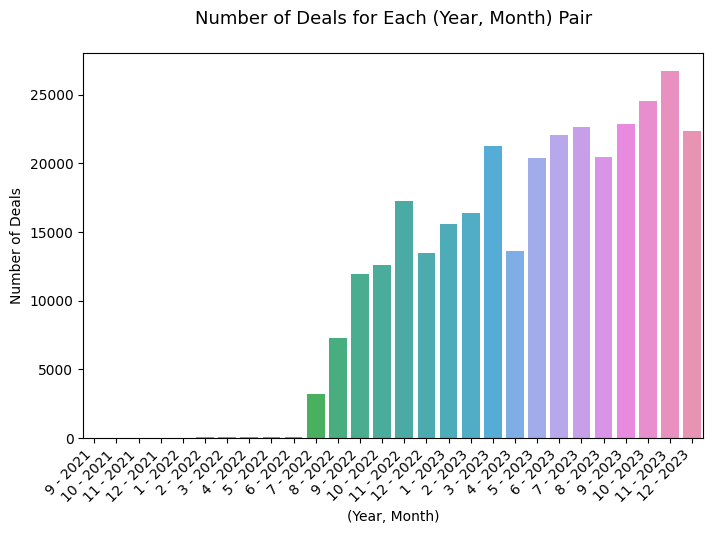

In [1182]:
# Extract year and month from 'Deal_Date'
counts_df = df_preprocessed.groupby(['Year_dealdate', 'Month_dealdate']).size().reset_index(name='Counts')
counts_df['Month_Year_dealdate'] = counts_df['Month_dealdate'].astype(str) + ' - ' + counts_df['Year_dealdate'].astype(str)

# Plot the histogram
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Month_Year_dealdate', y='Counts', data=counts_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Number of Deals for Each (Year, Month) Pair\n', fontsize=13)
plt.xlabel('(Year, Month)')
plt.ylabel('Number of Deals')
plt.show()

##### **Maturity analysis**

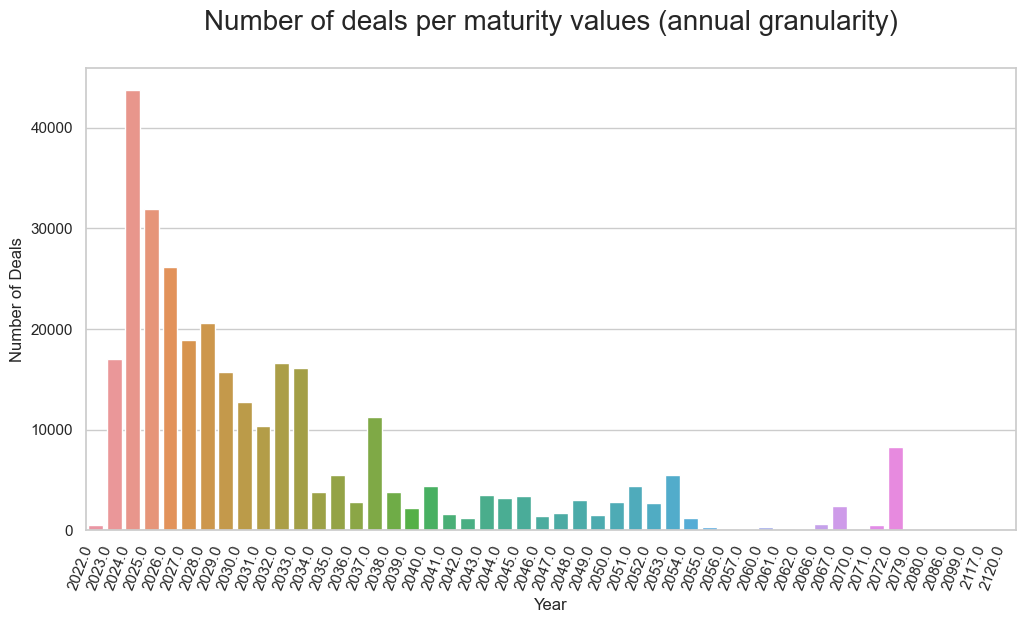

In [1428]:
df_maturity = df_preprocessed.dropna(subset=['maturity'], inplace=False)
df_maturity = df_maturity.groupby('Year_maturity').size().reset_index(name='Counts')
df_maturity.sort_values(by='Year_maturity', ascending=True)

# Plot the histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Year_maturity', y='Counts', data=df_maturity)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
plt.title('Number of deals per maturity values (annual granularity)\n', fontsize=20)
plt.xlabel('Year')
plt.ylabel('Number of Deals')
plt.show()

##### **Client (Company_short_name) analysis**

In [1429]:
number_of_comp = len(df_preprocessed.company_short_name.values)
print("Number of companies : ", number_of_comp)

Number of companies :  314678


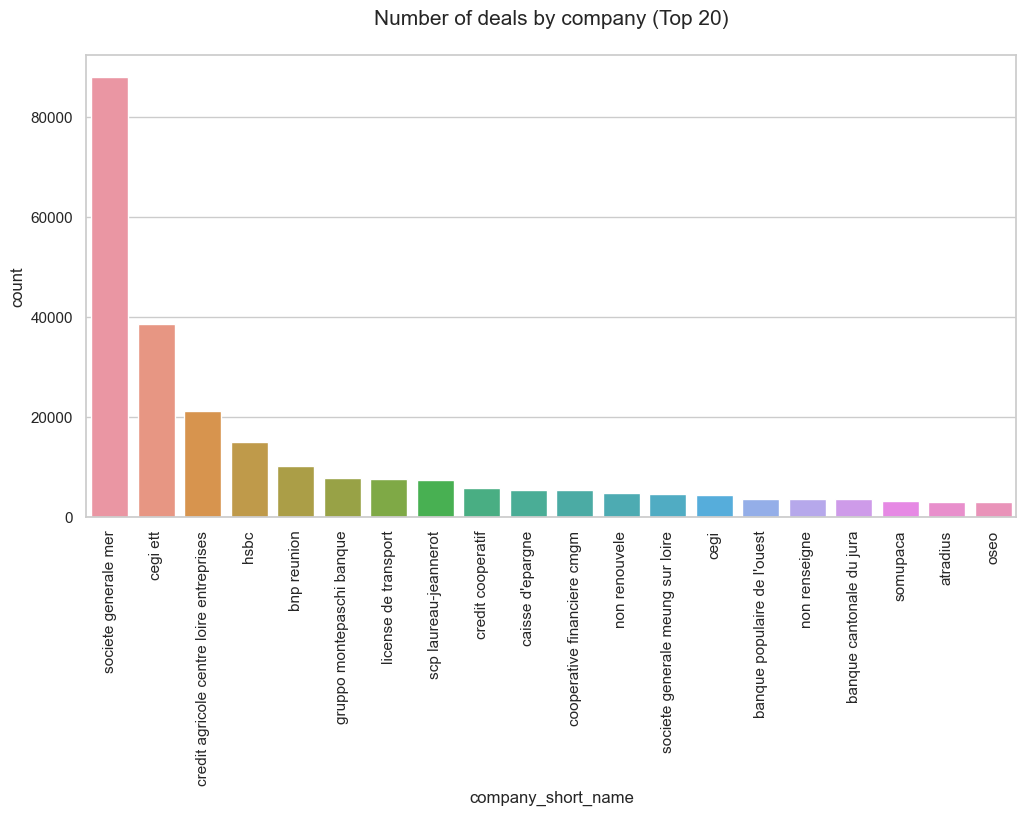

In [1432]:
# Histogramme du nombre de deals par company_short_name (top 20)
plt.figure(figsize=(12, 6))
top_20_companies = df_preprocessed['company_short_name'].value_counts().head(20)
sns.countplot(x='company_short_name', data=df_preprocessed, order=top_20_companies.index)
plt.title('Number of deals by company (Top 20)\n', fontsize=15)
plt.xticks(rotation=90)
plt.show()


##### **B_Sides analysis**

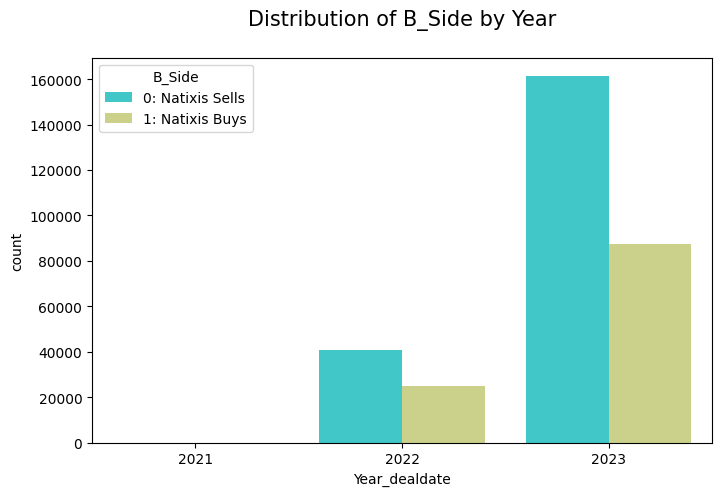

In [1186]:
plt.figure(figsize=(8, 5))
palette = sns.color_palette("rainbow", n_colors=2)
sns.countplot(x='Year_dealdate', hue='B_Side', data=df_preprocessed, palette=palette)
plt.legend(title='B_Side', labels=['0: Natixis Sells', '1: Natixis Buys'])
plt.title('Distribution of B_Side by Year\n', fontsize=15)
plt.show()

##### **BloomIndustrySector analysis**

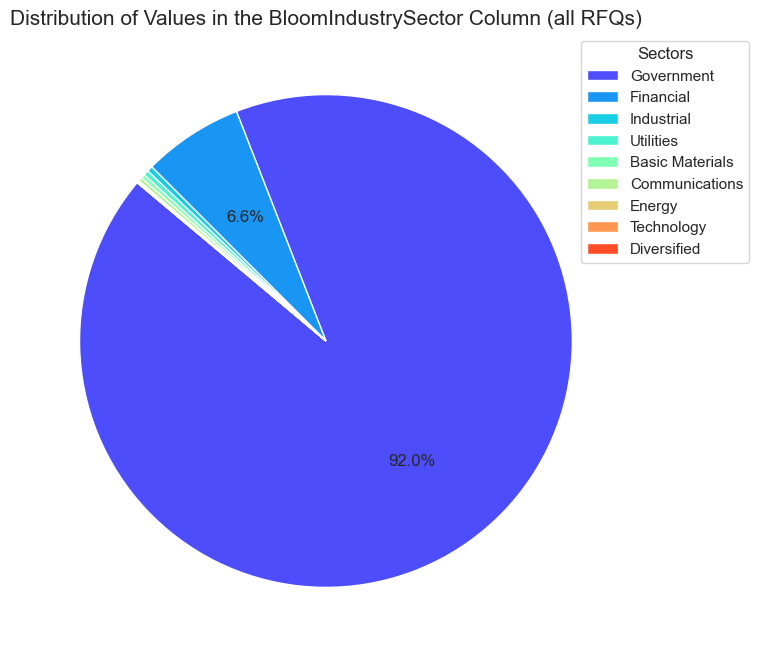

In [1433]:
sector_counts = df_preprocessed['BloomIndustrySector'].value_counts()
colors = sns.color_palette('rainbow', len(sector_counts))

# Set the threshold for displaying percentages
percentage_threshold = 2
def autopct_func(pct):
    return f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart without labels
plt.figure(figsize=(10, 8))
plt.pie(sector_counts, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(sector_counts.index, title='Sectors', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Values in the BloomIndustrySector Column (all RFQs)', fontsize=15)
plt.show()


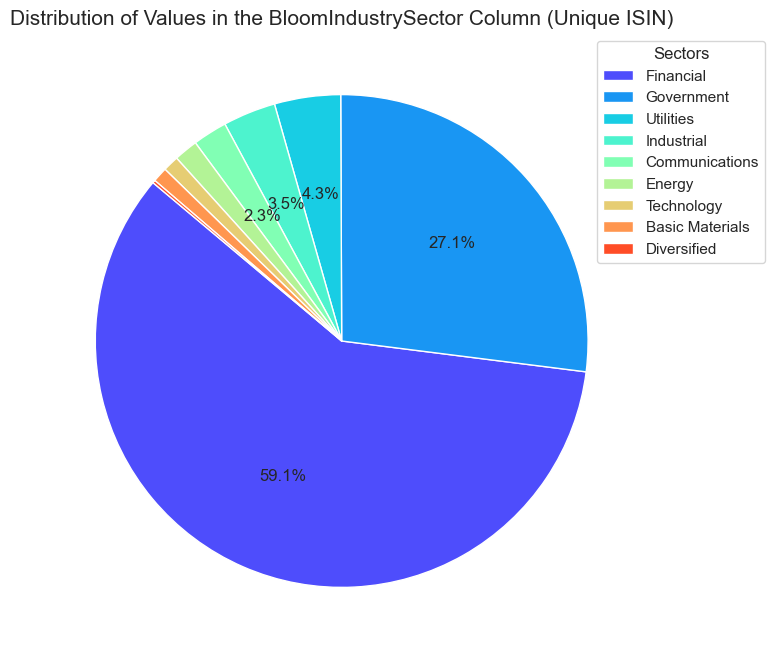

In [1434]:
# Group by unique 'ISIN' and keep the first row for each group
df_unique_isin = df_preprocessed.groupby('ISIN').first()

# Count the occurrences of each sector in the new DataFrame
sector_counts_unique_isin = df_unique_isin['BloomIndustrySector'].value_counts()

# Plot the pie chart with the new DataFrame
colors = sns.color_palette('rainbow', len(sector_counts_unique_isin))

# Set the threshold for displaying percentages
percentage_threshold = 2
def autopct_func(pct):
    return f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart without labels
plt.figure(figsize=(10, 8))
plt.pie(sector_counts_unique_isin, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(sector_counts_unique_isin.index, title='Sectors', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Values in the BloomIndustrySector Column (Unique ISIN)', fontsize=15)
plt.show()


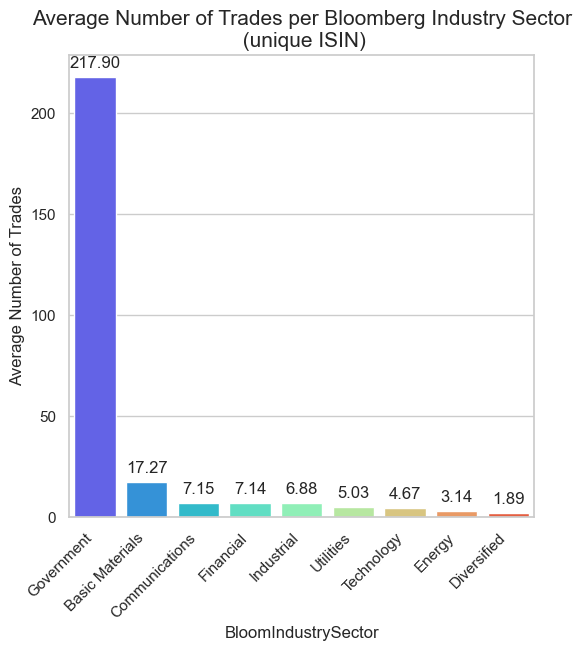

In [1436]:
df_industry = df_preprocessed[['ISIN', 'BloomIndustrySector']].copy()
df_count_trades = df_industry.groupby('ISIN').agg(Count=('BloomIndustrySector', 'count'), First_BloomIndustrySector=('BloomIndustrySector', 'first')).reset_index()
df_avg_trades_per_group = df_count_trades.groupby('First_BloomIndustrySector')['Count'].mean().reset_index()
df_avg_trades_per_group.sort_values(by='Count', ascending=False, inplace=True)

# Plot the bar chart for average number of trades per BloomIndustrySector
plt.figure(figsize=(6, 6))
ax = sns.barplot(x='First_BloomIndustrySector', y='Count', data=df_avg_trades_per_group, palette='rainbow')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Trades per Bloomberg Industry Sector\n (unique ISIN)', fontsize=15)
plt.xlabel('BloomIndustrySector')
plt.ylabel('Average Number of Trades')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()


In [1437]:
# Look at sector
df_unique_isin = df_preprocessed.groupby('ISIN').first()
sector_counts_unique_isin = df_unique_isin['BloomIndustrySector'].value_counts()
sector_counts_unique_isin


BloomIndustrySector
Financial          2903
Government         1329
Utilities           213
Industrial          170
Communications      111
Energy               77
Technology           51
Basic Materials      48
Diversified           9
Name: count, dtype: int64

In [1438]:
# Look at Industry group
number_industries = len(df_unique_isin['BloomIndustryGroup'].unique())
print('Number of industries : ', number_industries)
df_unique_isin.BloomIndustryGroup.value_counts()

Number of industries :  42


BloomIndustryGroup
Banks                       2361
Sovereign                    883
Diversified Finan Serv       347
Regional(state/provnc)       244
Multi-National               185
Electric                     173
Telecommunications            65
Oil&Gas                       62
Transportation                59
REITS                         59
Insurance                     55
Real Estate                   36
Computers                     31
Engineering&Construction      31
Internet                      29
Savings&Loans                 28
Chemicals                     27
Water                         24
Electrical Compo&Equip        19
Miscellaneous Manufactur      18
Municipal                     17
Aerospace/Defense             17
Gas                           16
Building Materials            15
Investment Companies          15
Media                         14
Software                      12
Iron/Steel                    11
Mining                        10
Pipelines               

In [1439]:
df_financial = df_unique_isin[df_unique_isin['BloomIndustrySector']=='Financial']
df_financial.BloomIndustryGroup.value_counts()

BloomIndustryGroup
Banks                     2361
Diversified Finan Serv     347
REITS                       59
Insurance                   55
Real Estate                 36
Savings&Loans               28
Investment Companies        15
Private Equity               2
Name: count, dtype: int64

In [1440]:
df_government = df_unique_isin[df_unique_isin['BloomIndustrySector']=='Government']
df_government.BloomIndustryGroup.value_counts()

BloomIndustryGroup
Sovereign                 883
Regional(state/provnc)    244
Multi-National            185
Municipal                  17
Name: count, dtype: int64

In [1441]:
df_utilities = df_unique_isin[df_unique_isin['BloomIndustrySector']=='Utilities']
df_utilities.BloomIndustryGroup.value_counts()

BloomIndustryGroup
Electric    173
Water        24
Gas          16
Name: count, dtype: int64

In [1442]:
df_industrial = df_unique_isin[df_unique_isin['BloomIndustrySector']=='Industrial']
df_industrial.BloomIndustryGroup.value_counts()

BloomIndustryGroup
Transportation              59
Engineering&Construction    31
Electrical Compo&Equip      19
Miscellaneous Manufactur    18
Aerospace/Defense           17
Building Materials          15
Environmental Control        4
Packaging&Containers         3
Machinery-Constr&Mining      2
Trucking&Leasing             1
Shipbuilding                 1
Name: count, dtype: int64

In [1443]:
df_communication = df_unique_isin[df_unique_isin['BloomIndustrySector']=='Communications']
df_communication.BloomIndustryGroup.value_counts()

BloomIndustryGroup
Telecommunications    65
Internet              29
Media                 14
Advertising            3
Name: count, dtype: int64

In [1444]:
df_energy = df_unique_isin[df_unique_isin['BloomIndustrySector']=='Energy']
df_energy.BloomIndustryGroup.value_counts()

BloomIndustryGroup
Oil&Gas                     62
Pipelines                   10
Oil&Gas Services             3
Energy-Alternate Sources     2
Name: count, dtype: int64

In [1445]:
df_technology = df_unique_isin[df_unique_isin['BloomIndustrySector']=='Technology']
df_technology.BloomIndustryGroup.value_counts()

BloomIndustryGroup
Computers                31
Software                 12
Semiconductors            7
Office/Business Equip     1
Name: count, dtype: int64

In [1446]:
df_basic_materials = df_unique_isin[df_unique_isin['BloomIndustrySector']=='Basic Materials']
df_basic_materials.BloomIndustryGroup.value_counts()

BloomIndustryGroup
Chemicals     27
Iron/Steel    11
Mining        10
Name: count, dtype: int64

In [1447]:
df_diversified = df_unique_isin[df_unique_isin['BloomIndustrySector']=='Diversified']
df_diversified.BloomIndustryGroup.value_counts()

BloomIndustryGroup
Holding Companies-Divers    9
Name: count, dtype: int64

In [1448]:
# Look at Industry subgroup
number_subindustries = len(df_unique_isin['BloomIndustrySubGroup'].unique())
print('Number of sub industries : ', number_subindustries)
df_unique_isin.BloomIndustrySubGroup.value_counts()

Number of sub industries :  115


BloomIndustrySubGroup
Commer Banks Non-US         1318
Sovereign                    593
Diversified Banking Inst     471
Sovereign Agency             249
Special Purpose Banks        230
                            ... 
Oil Refining&Marketing         1
Office Automation&Equip        1
Shipbuilding                   1
Transport-Equip&Leasng         1
Internet Connectiv Svcs        1
Name: count, Length: 115, dtype: int64

In [1449]:
df_financial = df_unique_isin[df_unique_isin['BloomIndustryGroup']=='Banks']
df_financial.BloomIndustrySubGroup.value_counts()

BloomIndustrySubGroup
Commer Banks Non-US         1318
Diversified Banking Inst     471
Special Purpose Banks        230
Mortgage Banks               175
Regional Banks-Non US         98
Cooperative Banks             36
Money Center Banks            17
Super-Regional Banks-US       13
Fiduciary Banks                3
Name: count, dtype: int64

In [1450]:
df_government = df_unique_isin[df_unique_isin['BloomIndustryGroup']=='Sovereign']
df_government.BloomIndustrySubGroup.value_counts()

BloomIndustrySubGroup
Sovereign             593
Sovereign Agency      249
Export/Import Bank     41
Name: count, dtype: int64

##### **Days_to_Maturity analysis**

In [1451]:
df_unique_isin = df_preprocessed.groupby('ISIN').first()
df_unique_isin.Days_to_Maturity.describe()

count     4911.000000
mean      1991.390145
std       2487.601295
min       -206.000000
25%        655.500000
50%       1465.000000
75%       2479.500000
max      35752.000000
Name: Days_to_Maturity, dtype: float64

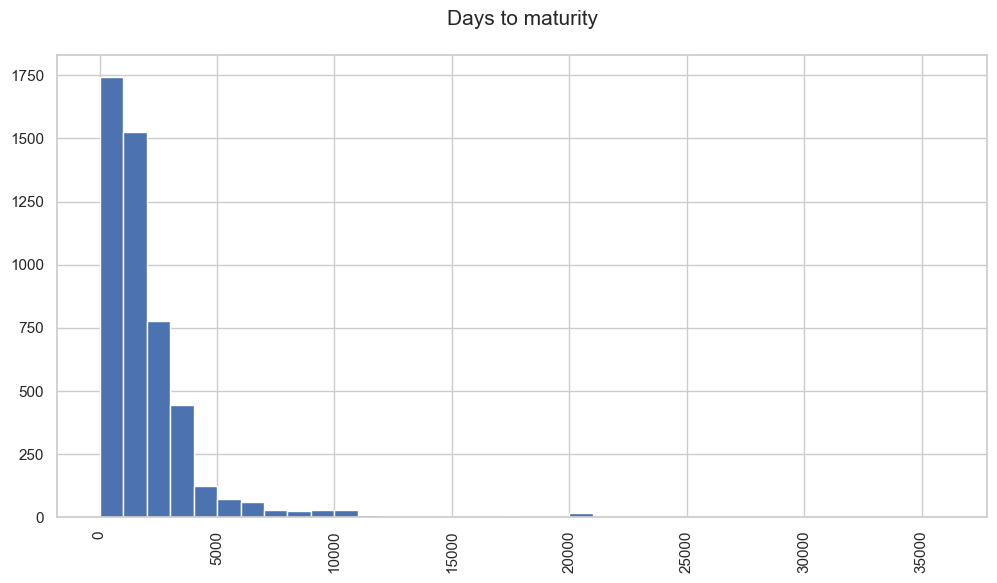

In [1453]:
# Histogram of the number of deals per company_short_name (top 20) with bins of size 50
df_unique_isin = df_preprocessed.groupby('ISIN').first()
plt.figure(figsize=(12, 6))
plt.hist(df_unique_isin['Days_to_Maturity'], bins=range(0, max(df_preprocessed['Days_to_Maturity']) + 1000, 1000))
plt.title('Days to maturity\n', fontsize=15)
plt.xticks(rotation=90)
plt.show()


##### **Fitch Credit rating**

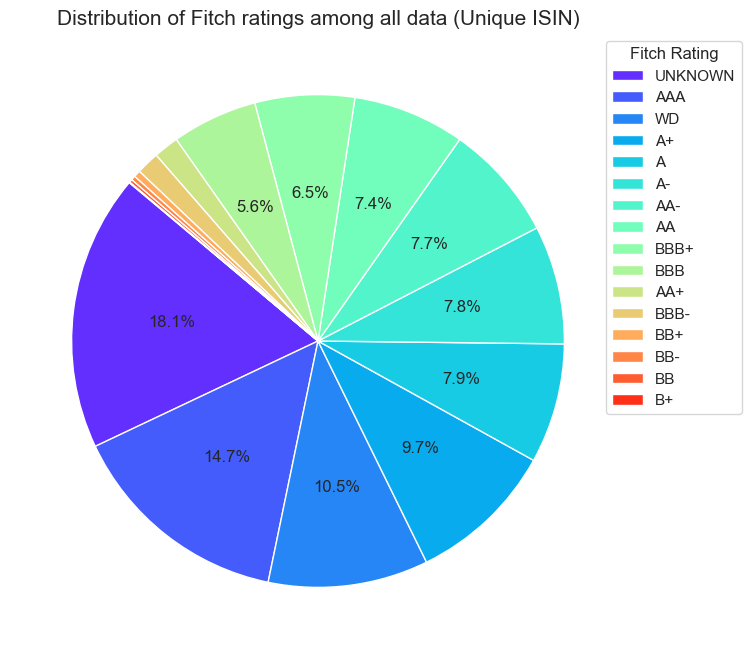

In [1454]:
# Group by unique 'ISIN' and keep the first row for each group
df_unique_isin = df_preprocessed.groupby('ISIN').first()

# Count the occurrences of each sector in the new DataFrame
sector_counts_unique_isin = df_unique_isin['Rating_Fitch'].value_counts()

# Plot the pie chart with the new DataFrame
colors = sns.color_palette('rainbow', len(sector_counts_unique_isin))

# Set the threshold for displaying percentages
percentage_threshold = 2
def autopct_func(pct):
    return f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart without labels
plt.figure(figsize=(10, 8))
plt.pie(sector_counts_unique_isin, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(sector_counts_unique_isin.index, title='Fitch Rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Fitch ratings among all data (Unique ISIN)', fontsize=15)
plt.show()


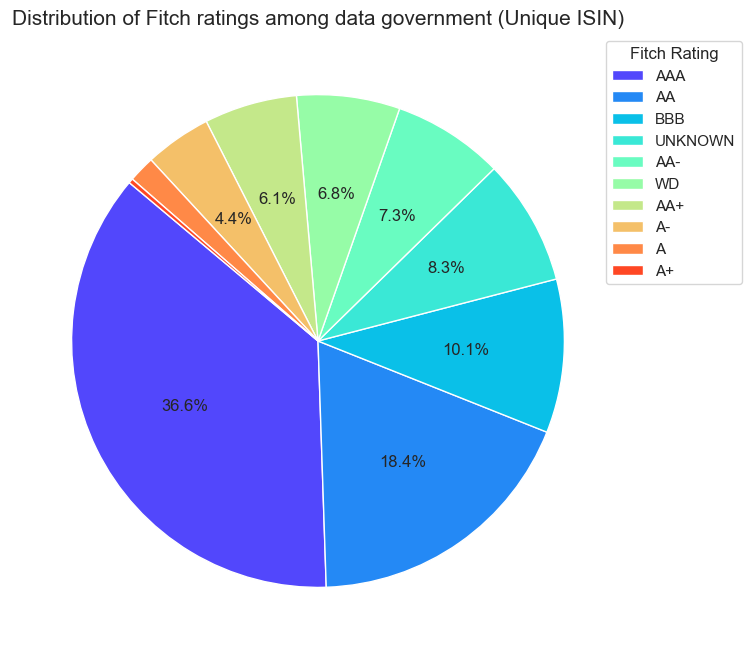

In [1455]:
# Group by unique 'ISIN' and keep the first row for each group
df_unique_isin = df_preprocessed.groupby('ISIN').first()

df_government = df_unique_isin[df_unique_isin['BloomIndustrySector']=='Government'].copy()

# Count the occurrences of each sector in the new DataFrame
sector_counts_unique_isin = df_government['Rating_Fitch'].value_counts()

# Plot the pie chart with the new DataFrame
colors = sns.color_palette('rainbow', len(sector_counts_unique_isin))

# Set the threshold for displaying percentages
percentage_threshold = 2
def autopct_func(pct):
    return f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart without labels
plt.figure(figsize=(10, 8))
plt.pie(sector_counts_unique_isin, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(sector_counts_unique_isin.index, title='Fitch Rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Fitch ratings among data government (Unique ISIN)', fontsize=15)
plt.show()


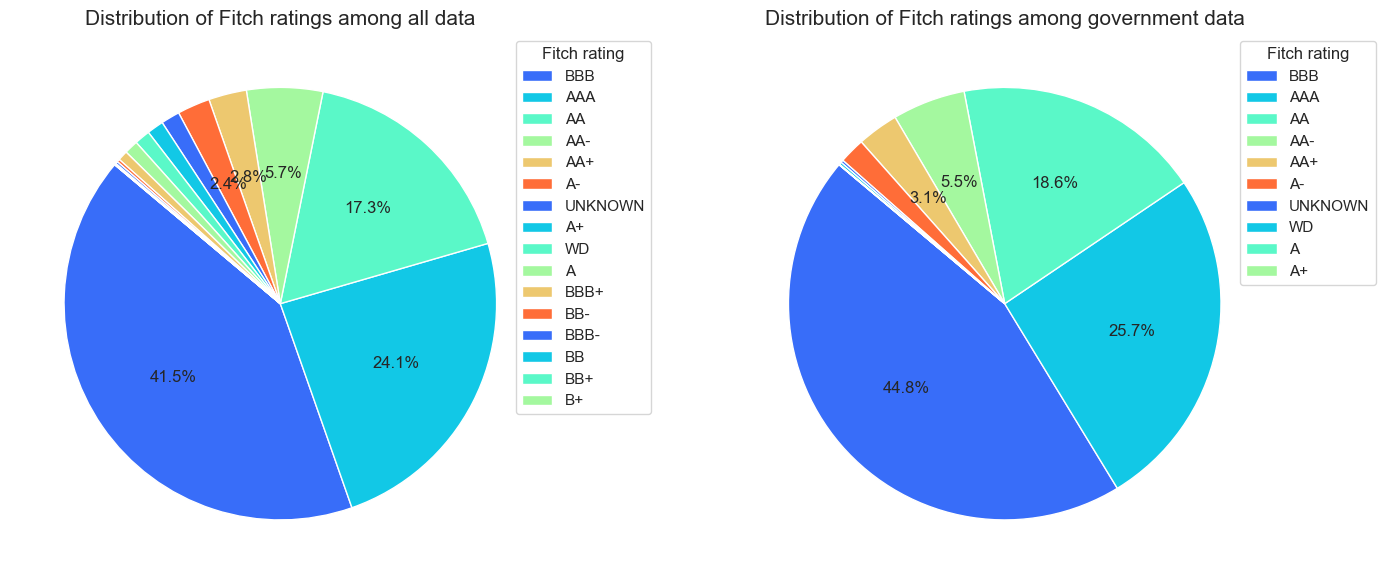

In [1456]:
# Set the common attributes
colors = sns.color_palette('rainbow')
percentage_threshold = 2
autopct_func = lambda pct: f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart for the entire dataset
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
Fitch_counts_all = df_preprocessed['Rating_Fitch'].value_counts()
plt.pie(Fitch_counts_all, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(Fitch_counts_all.index, title='Fitch rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Fitch ratings among all data', fontsize=15)

# Plot the pie chart for the government data
plt.subplot(1, 2, 2)
df_government = df_preprocessed[df_preprocessed['BloomIndustrySector']=='Government'].copy()
Fitch_counts_government = df_government['Rating_Fitch'].value_counts()
plt.pie(Fitch_counts_government, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(Fitch_counts_government.index, title='Fitch rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Fitch ratings among government data', fontsize=15)

# Adjust layout
plt.tight_layout()
plt.show()


##### **Moodys Credit rating**

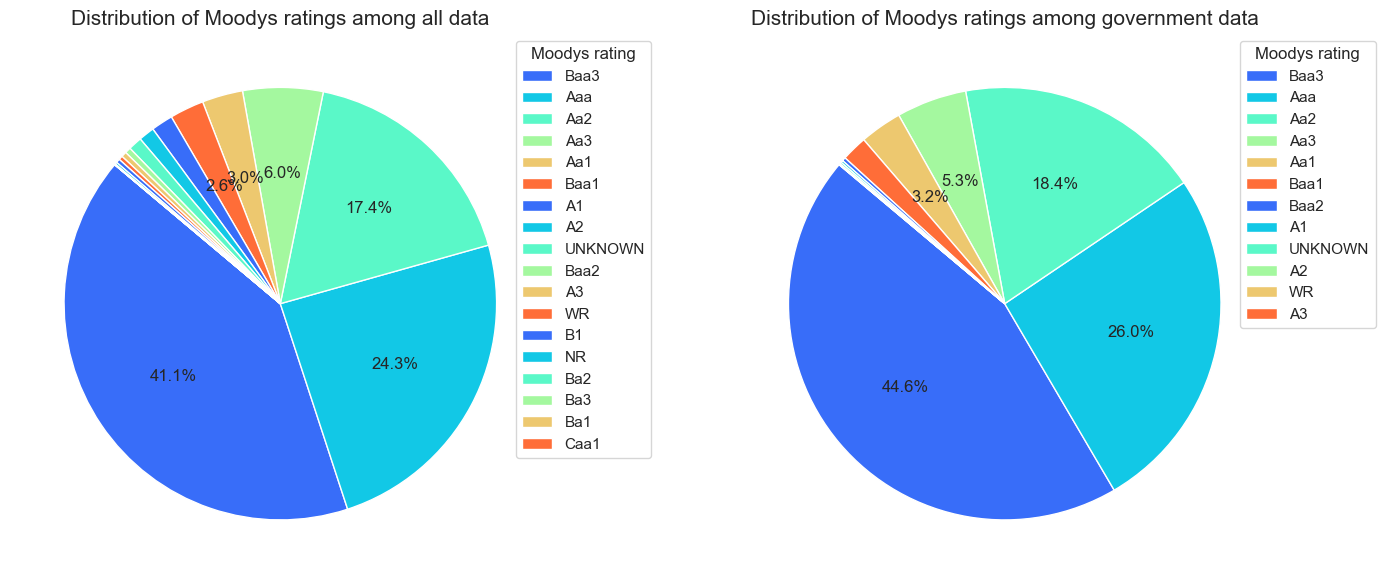

In [1457]:
# Set the common attributes
colors = sns.color_palette('rainbow')
percentage_threshold = 2
autopct_func = lambda pct: f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart for the entire dataset
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
moodys_counts_all = df_preprocessed['Rating_Moodys'].value_counts()
plt.pie(moodys_counts_all, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(moodys_counts_all.index, title='Moodys rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Moodys ratings among all data', fontsize=15)

# Plot the pie chart for the government data
plt.subplot(1, 2, 2)
df_government = df_preprocessed[df_preprocessed['BloomIndustrySector']=='Government'].copy()
moodys_counts_all = df_government['Rating_Moodys'].value_counts()
plt.pie(moodys_counts_all, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(moodys_counts_all.index, title='Moodys rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Moodys ratings among government data', fontsize=15)

# Adjust layout
plt.tight_layout()
plt.show()


##### **SP Credit rating**

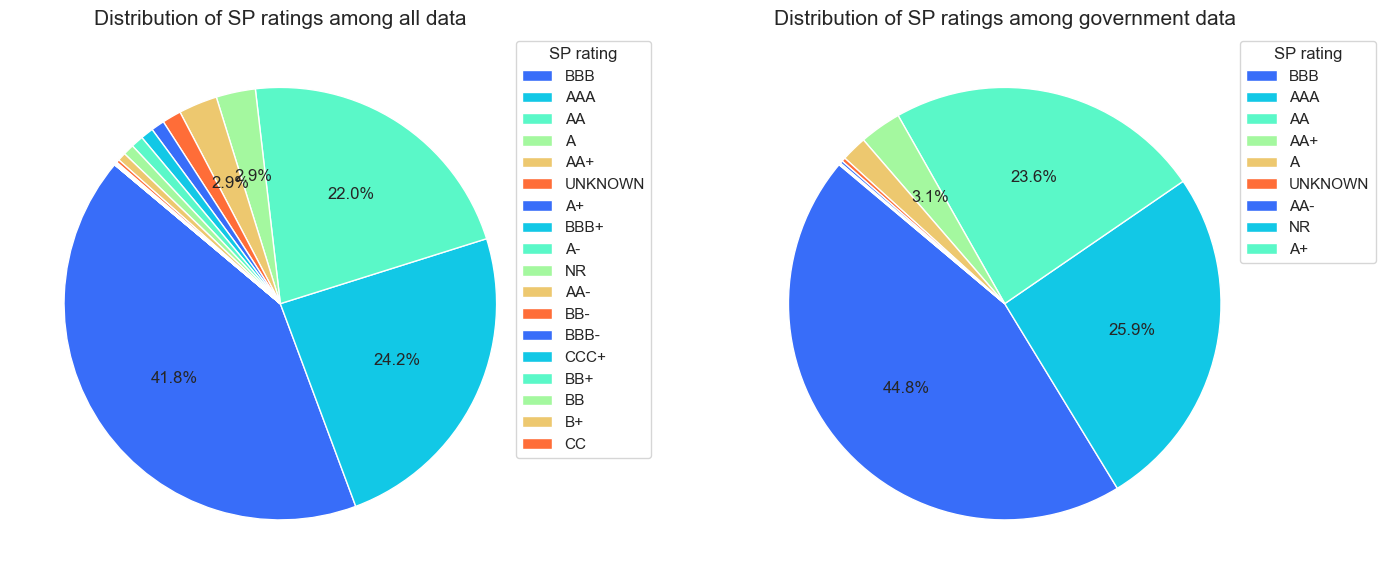

In [1458]:
# Set the common attributes
colors = sns.color_palette('rainbow')
percentage_threshold = 2
autopct_func = lambda pct: f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart for the entire dataset
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
moodys_counts_all = df_preprocessed['Rating_SP'].value_counts()
plt.pie(moodys_counts_all, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(moodys_counts_all.index, title='SP rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of SP ratings among all data', fontsize=15)

# Plot the pie chart for the government data
plt.subplot(1, 2, 2)
df_government = df_preprocessed[df_preprocessed['BloomIndustrySector']=='Government'].copy()
moodys_counts_all = df_government['Rating_SP'].value_counts()
plt.pie(moodys_counts_all, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(moodys_counts_all.index, title='SP rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of SP ratings among government data', fontsize=15)

# Adjust layout
plt.tight_layout()
plt.show()


##### **Currency analysis**

In [1459]:
# Count the occurrences of each currency
ccy_counts = df_preprocessed['Ccy'].value_counts()
print(ccy_counts)

Ccy
EUR    313060
USD      1617
GBP         1
Name: count, dtype: int64


In [1460]:
# Count the occurrences of each currency
ccy_counts = df_preprocessed['Ccy'].value_counts()
ccy_percentage = ccy_counts / len(df_preprocessed) * 100
print(ccy_percentage)

Ccy
EUR    99.485824
USD     0.513859
GBP     0.000318
Name: count, dtype: float64


The great majority of bonds (99.5%) are in euros.

##### **Bond Price analysis (B_price)**

In [1461]:
# Group by unique 'ISIN' and keep the first row for each group
df_unique_isin = df_preprocessed.groupby('ISIN').first()

df_EUR = df_unique_isin[df_unique_isin['Ccy']=='EUR']
df_EUR['B_Price'].describe()

count    4424.000000
mean       92.033454
std         9.567957
min        33.000000
25%        87.000000
50%        95.000000
75%        99.000000
max       137.000000
Name: B_Price, dtype: float64

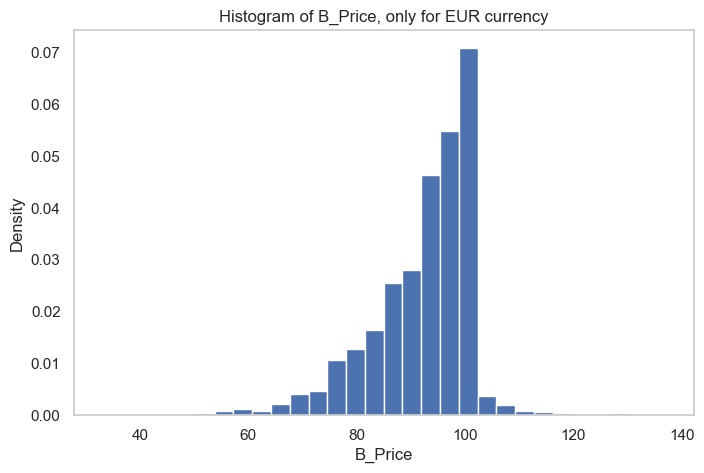

In [1463]:
plt.figure(figsize=(8, 5))
df_EUR['B_Price'].hist(bins=30, grid=False, density=True)
plt.title('Histogram of B_Price, only for EUR currency')
plt.xlabel('B_Price')
plt.ylabel('Density')
plt.show()


##### **Country analysis**

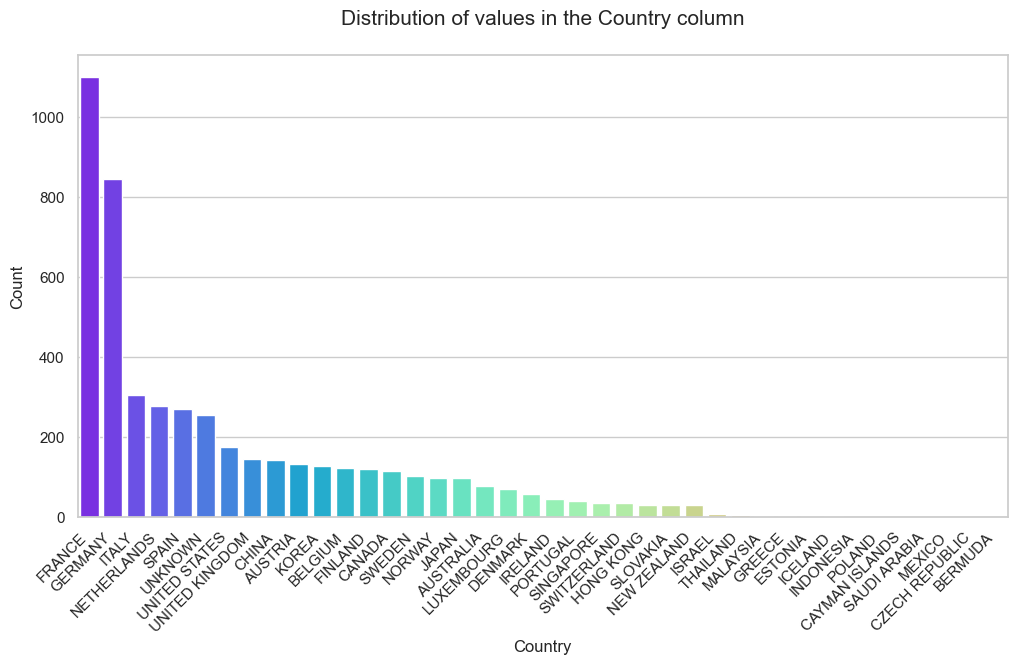

In [1464]:
df_unique_isin = df_preprocessed.groupby('ISIN').first()
country_counts = df_unique_isin['Country'].value_counts()

# Plot the bar chart for country columns
plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.index, y=country_counts, palette='rainbow')
plt.title('Distribution of values in the Country column\n', fontsize = 15)
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()


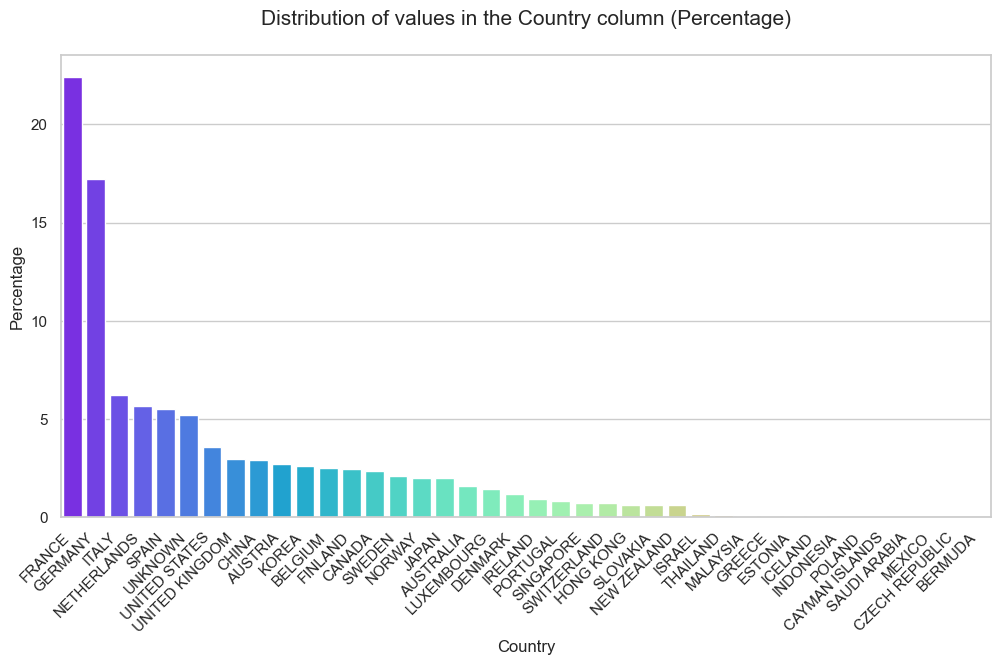

In [1465]:
# Calculate the percentage distribution
country_percentage = (country_counts / country_counts.sum()) * 100

# Plot the bar chart for country columns with percentages
plt.figure(figsize=(12, 6))
sns.barplot(x=country_percentage.index, y=country_percentage, palette='rainbow')
plt.title('Distribution of values in the Country column (Percentage)\n', fontsize = 15)
plt.xlabel('Country')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()


In [1466]:
country_percentage.head(5)

Country
FRANCE         22.419059
GERMANY        17.206272
ITALY           6.190185
NETHERLANDS     5.660762
SPAIN           5.497862
Name: count, dtype: float64

The majority are Italian, French and German bonds.

##### **Coupon analysis**

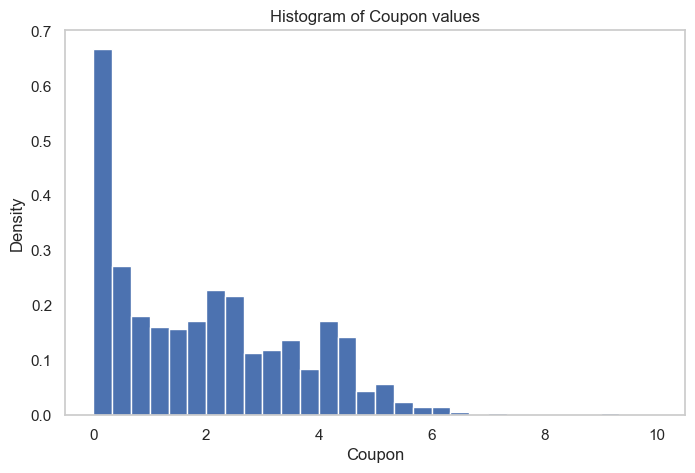

In [1467]:
plt.figure(figsize=(8, 5))
df_preprocessed['Coupon'].hist(bins=30, grid=False, density=True)
plt.title('Histogram of Coupon values')
plt.xlabel('Coupon')
plt.ylabel('Density')
plt.show()


In [1468]:
df_preprocessed.GSpreadMid.describe()

count    314678.000000
mean         69.377004
std          45.105148
min        -325.936432
25%          53.632078
50%          53.632078
75%          66.357435
max        4707.474609
Name: GSpreadMid, dtype: float64

## 4° Exploring the heterogeneity of clients and bonds

- **Exploring the heterogeneity of clients** (p.13 of the thesis): most active client ? What is he accounting for among all performed RFQs ? Find something like '80% of the accounted RFQs were made by less than 10% of the client pool'. Plot the graph Cumulative propoertion of clients as a function of cumulative proportion of RFQs.


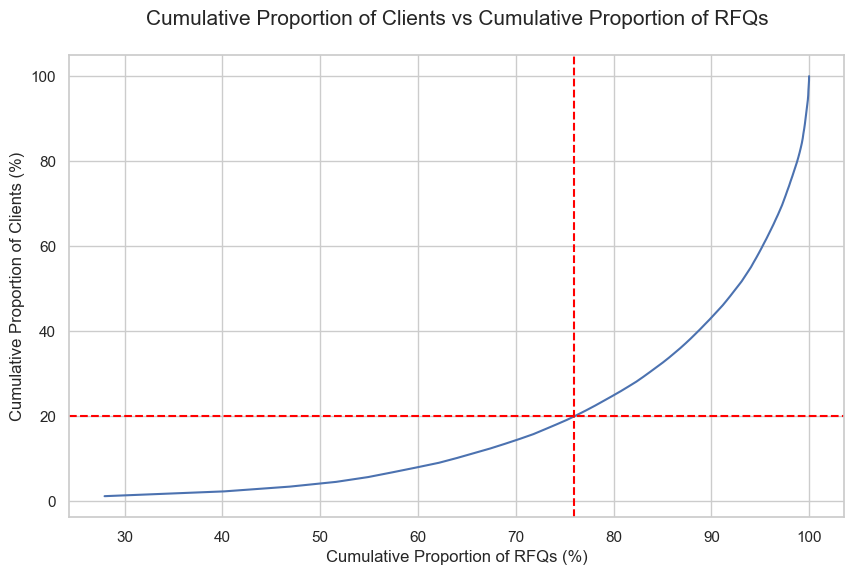

In [1469]:
# Generate the dataframe
df_clients = df_preprocessed[['ISIN', 'company_short_name']]
df_RFQ_count = df_clients.groupby(by='company_short_name').agg(count=('company_short_name','count')).reset_index()
df_RFQ_count.columns = ['company_short_name', 'RFQ_count']
total_RFQ_transactions = df_RFQ_count.RFQ_count.sum()
df_RFQ_count['RFQ_count_perc'] = df_RFQ_count['RFQ_count']*100/total_RFQ_transactions

df_RFQ_count.sort_values(by='RFQ_count', ascending=False, inplace=True)
df_RFQ_count['client_number'] = 1
df_RFQ_count['cum_sum_client'] = np.round(df_RFQ_count['client_number'].cumsum() * 100 /(df_RFQ_count.shape[0]), 2)
df_RFQ_count.drop(columns=['client_number'], inplace=True)
df_RFQ_count['cum_sum_RFQ'] = np.round(df_RFQ_count['RFQ_count_perc'].cumsum(), 2)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.plot(df_RFQ_count['cum_sum_RFQ'], df_RFQ_count['cum_sum_client'], linestyle='-')
plt.title('Cumulative Proportion of Clients vs Cumulative Proportion of RFQs\n', fontsize=15)
plt.xlabel('Cumulative Proportion of RFQs (%)')
plt.ylabel('Cumulative Proportion of Clients (%)')
plt.axvline(x=76, color='red', linestyle='--') 
plt.axhline(y=20, color='red', linestyle='--') 
plt.grid(True)
plt.show()

In [1470]:
df_RFQ_count.head()

,company_short_name,RFQ_count,RFQ_count_perc,cum_sum_client,cum_sum_RFQ
86,societe generale mer,87951,27.949523,1.12,27.95
38,cegi ett,38541,12.247758,2.25,40.20
48,credit agricole centre loire entreprises,21085,6.700500,3.37,46.90
65,hsbc,14932,4.745168,4.49,51.64
16,bnp reunion,10281,3.267149,5.62,54.91


In [1471]:
df_RFQ_count[df_RFQ_count['cum_sum_client']>20].head()

,company_short_name,RFQ_count,RFQ_count_perc,cum_sum_client,cum_sum_RFQ
88,somupaca,3153,1.001977,20.22,76.25
5,atradius,3044,0.967338,21.35,77.22
74,oseo,2898,0.920941,22.47,78.14
36,cegc,2763,0.878040,23.60,79.02
67,maitre bondroit,2756,0.875816,24.72,79.89


Observations regarding the heterogeneity of clients : 
- The **most active client** (societe generale mer) accounted for 27.95% of all performed RFQs alone 
- **76% of the accounted RFQs** were made by less of **20% of the client pool**


**Exploring the heterogeneity of bonds**  (p.13 of the thesis): % of bonds that are shared among several clients ? Find somthing like '80% of the RFQs were done on more than 30% of the considered assets.' Plot the cumulative number of assets as a function of the cumulative proportion of RFQs.

In [1472]:
df_bonds = df_preprocessed[['ISIN', 'cdcissuer']].copy()
df_bonds = df_bonds.groupby(by='ISIN').agg('count').reset_index()
df_bonds.columns= ['ISIN', 'count']
df_bonds.sort_values(by='count', ascending=False, inplace=True)
total_bond = df_preprocessed.shape[0]
df_bonds['count_perc'] = np.round(df_bonds['count']*100/total_bond, 2)
df_bonds.head()

,ISIN,count,count_perc
2225,IT0003934657,8333,2.65
2343,IT0005441883,4212,1.34
2333,IT0005425233,4190,1.33
1803,FR0014001NN8,4033,1.28
2369,IT0005518128,3980,1.26


In [1473]:
df_bonds = df_preprocessed[['ISIN', 'cdcissuer']].copy()
df_bonds = df_bonds.groupby(by='cdcissuer').agg('count').reset_index()
df_bonds.columns = ['cdcissuer', 'count']
df_bonds.sort_values(by='count', ascending=False, inplace=True)
total_bond = df_preprocessed.shape[0]
df_bonds['count_perc'] = np.round(df_bonds['count']*100/total_bond, 2)
df_bonds.head()

,cdcissuer,count,count_perc
122,BTP,129018,41.00
289,FRENCH REPUBLIC GOVERNMENT BOND OAT,51777,16.45
124,BUNDESREPUBLIK DEUTSCHLAND BUNDESANLEIHE,33257,10.57
376,KINGDOM OF BELGIUM GOVERNMENT BOND,15105,4.80
471,NETHERLANDS GOVERNMENT BOND,14467,4.60


First line where the cumulated sum of RFQs is higher than 80% :
ISIN                 BE0000333428
count_perc                   0.11
count_perc_cumsum           80.03
cum_sum_asset                5.23
Name: 88, dtype: object


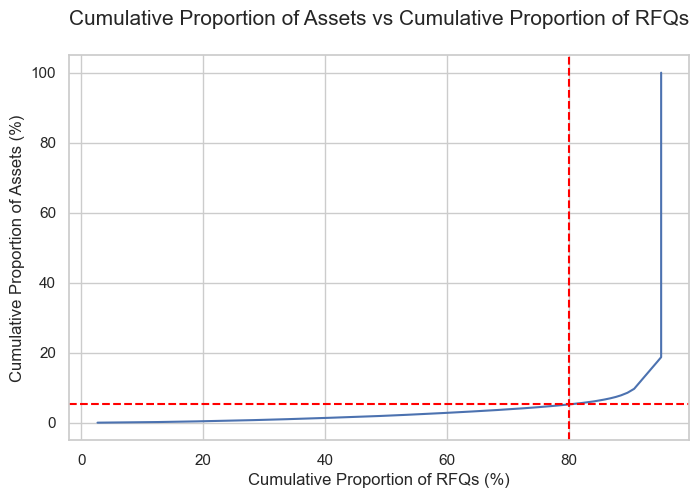

In [1474]:
df_bonds = df_preprocessed[['ISIN', 'cdcissuer']].copy()
df_bonds = df_bonds.groupby(by='ISIN').agg('count').reset_index()
df_bonds.columns= ['ISIN', 'count']
df_bonds.sort_values(by='count', ascending=False, inplace=True)
total_bond = df_preprocessed.shape[0]
df_bonds['count_perc'] = np.round(df_bonds['count']*100/total_bond, 2)
df_bonds['count_perc_cumsum'] = df_bonds['count_perc'].cumsum()

df_bonds['number_asset'] = 1
total_asset = df_bonds.shape[0]
df_bonds['cum_sum_asset'] = np.round(df_bonds['number_asset'].cumsum()*100/total_asset, 2)
df_bonds.drop(columns=['number_asset', 'count'], inplace=True)

print('First line where the cumulated sum of RFQs is higher than 80% :')
df_higher_20 = df_bonds[df_bonds['count_perc_cumsum']>80]
print(df_higher_20.iloc[0])

# Plot the histogram 
plt.figure(figsize=(8, 5))
plt.plot(df_bonds['count_perc_cumsum'], df_bonds['cum_sum_asset'], linestyle='-')
plt.title('Cumulative Proportion of Assets vs Cumulative Proportion of RFQs\n', fontsize=15)
plt.xlabel('Cumulative Proportion of RFQs (%)')
plt.ylabel('Cumulative Proportion of Assets (%)')
plt.axvline(x=80.01, color='red', linestyle='--') 
plt.axhline(y=5.23, color='red', linestyle='--') 
plt.grid(True)
plt.show()

Observations regarding the heterogeneity of bonds :
- The **most active bond** (ISIN : IT0003934657) accounted for 2.65% of the all RFQs
- The **most active bond issuer** (cdcissuer : BTP) accounted for 50% of all RFQs
- **80% of the RFQs** were done on a bit more than **5% of the considered assets**. The heterogeity of bonds is then well more pronounced that the heterogeity of clients.

**Conclusion :** Most clients only trade a handful of bonds, and most bonds are only traded by a handful of clients. This problemn is referred in the page 13/14 of the thesis as the **long tail problem** :

"It can consequently become diffcult to build recommender systems able to propose the entire asset pool to a given client, and reciprocally. This phenomenon is referred to in the literature as the long tail problem (Park and Tuzhilin, 2008), which refers to the fact that for most items, very few activity is recorded. Park and Tuzhilin (2008) proposes a way to tackle this by splitting the item pool in a head and tail parts and train models on each of these parts, the tail model being trained on clustered items. More broadly, the long tail is tackled by systems that favor diverse recommendations, i.e., recommendations that are made outside of the usual clients’ patterns."

## 5° Writing EDA functions

### 1. Bond Analysis functions (given ISIN code)

In [1558]:
ISIN_ex1 = 'AT0000383864'
ISIN_ex2 = 'AT0000A04967'
ISIN_ex3 = 'AT0000A0DXC2'
ISIN_ex4 = 'AT0000A0U299'

A. General Info display

In [1559]:
from tabulate import tabulate

def plot_double_general_info(df, ISIN1, ISIN2):
    
    # Filter DataFrame for ISIN1
    df_ISIN1 = df[df['ISIN'] == ISIN1].copy()
    df_ISIN1.sort_values(by='Deal_Date', inplace=True)
    
    # Filter DataFrame for ISIN2
    df_ISIN2 = df[df['ISIN'] == ISIN2].copy()
    df_ISIN2.sort_values(by='Deal_Date', inplace=True)

    # Check if the DataFrames are empty after filtering
    if df_ISIN1.empty or df_ISIN2.empty:
        return "No data found for the given ISINs."
    
    # Format the maturity date for ISIN1
    maturity_date1 = df_ISIN1.maturity.iloc[0].strftime("%Y-%m-%d %H:%M:%S")
    maturity_date1 = maturity_date1[:-9]  

    # Format the maturity date for ISIN2
    maturity_date2 = df_ISIN2.maturity.iloc[0].strftime("%Y-%m-%d %H:%M:%S")
    maturity_date2 = maturity_date2[:-9]  

    # Create a list of lists with data for both ISINs
    data = [
        [str(df_ISIN1.ISIN.iloc[0]) + ' (Initial)',
         df_ISIN1.BloomIndustrySector.iloc[0],
         df_ISIN1.BloomIndustrySubGroup.iloc[0],
         maturity_date1,
         np.round(df_ISIN1.Coupon.iloc[0], 2),
         df_ISIN1.Frequency.iloc[0],
        ],
        [df_ISIN2.ISIN.iloc[0]+ ' (Recommended)',
         df_ISIN2.BloomIndustrySector.iloc[0],
         df_ISIN2.BloomIndustrySubGroup.iloc[0],
         maturity_date2,
         np.round(df_ISIN2.Coupon.iloc[0], 2),
         df_ISIN2.Frequency.iloc[0],
        ]
    ]

    # Create a fancy grid table using tabulate
    table = tabulate(data, headers=["ISIN code", "Sector", "Industry Subgroup", 
                                    "Maturity", "Coupon", "Frequency"],
                     tablefmt='fancy_grid', numalign="center", stralign="center", colalign=("center",),
                     showindex=False)

    # Print the table
    print(table)

# Example usage:
plot_double_general_info(df_preprocessed, ISIN_ex1, ISIN_ex2)


╒════════════════════════════╤════════════╤═════════════════════╤════════════╤══════════╤═════════════╕
│         ISIN code          │   Sector   │  Industry Subgroup  │  Maturity  │  Coupon  │  Frequency  │
╞════════════════════════════╪════════════╪═════════════════════╪════════════╪══════════╪═════════════╡
│   AT0000383864 (Initial)   │ Government │      Sovereign      │ 2027-07-15 │   6.25   │     12      │
├────────────────────────────┼────────────┼─────────────────────┼────────────┼──────────┼─────────────┤
│ AT0000A04967 (Recommended) │ Government │      Sovereign      │ 2037-03-15 │   4.15   │     12      │
╘════════════════════════════╧════════════╧═════════════════════╧════════════╧══════════╧═════════════╛


In [1560]:
from tabulate import tabulate

def plot_double_general_info(df, initial_ISIN, df_similar_ISIN, probabilities):
    
    # Filter DataFrame for initial ISIN
    df_initial_ISIN = df[df['ISIN'] == initial_ISIN].copy()
    df_initial_ISIN.sort_values(by='Deal_Date', inplace=True)

    # Check if the DataFrame is empty after filtering
    if df_initial_ISIN.empty:
        return "No data found for the given initial ISIN."
    
    # Format the maturity date for initial ISIN
    maturity_date_initial = df_initial_ISIN.maturity.iloc[0].strftime("%Y-%m-%d %H:%M:%S")
    maturity_date_initial = maturity_date_initial[:-9]  

    # Create a list of lists with data for initial ISIN
    data = [
        [str(df_initial_ISIN.ISIN.iloc[0]) + ' (Initial)',
         df_initial_ISIN.BloomIndustrySector.iloc[0],
         df_initial_ISIN.BloomIndustrySubGroup.iloc[0],
         maturity_date_initial,
         np.round(df_initial_ISIN.Coupon.iloc[0], 2),
         df_initial_ISIN.Frequency.iloc[0],
         1  # Proximity value for the initial ISIN
        ]
    ]

    # Iterate through similar ISINs and probabilities
    for similar_ISIN, proximity in zip(df_similar_ISIN, probabilities):
        # Filter DataFrame for similar ISIN
        df_similar_ISIN = df[df['ISIN'] == similar_ISIN].copy()
        df_similar_ISIN.sort_values(by='Deal_Date', inplace=True)

        # Check if the DataFrame is empty after filtering
        if df_similar_ISIN.empty:
            continue

        # Format the maturity date for similar ISIN
        maturity_date_similar = df_similar_ISIN.maturity.iloc[0].strftime("%Y-%m-%d %H:%M:%S")
        maturity_date_similar = maturity_date_similar[:-9]  

        # Add data for similar ISIN to the list
        data.append([df_similar_ISIN.ISIN.iloc[0],
                     df_similar_ISIN.BloomIndustrySector.iloc[0],
                     df_similar_ISIN.BloomIndustrySubGroup.iloc[0],
                     maturity_date_similar,
                     np.round(df_similar_ISIN.Coupon.iloc[0], 2),
                     df_similar_ISIN.Frequency.iloc[0],
                     proximity  # Proximity value for the similar ISIN
                    ])

    # Create a fancy grid table using tabulate
    table = tabulate(data, headers=["ISIN code", "Sector", "Industry Subgroup", 
                                    "Maturity", "Coupon", "Frequency", "Proximity"],
                     tablefmt='fancy_grid', numalign="center", stralign="center", colalign=("center",),
                     showindex=False)

    # Print the table
    print(table)

# Example usage:
initial_ISIN = 'NL0011220108'
df_similar_ISIN = ['AT0000383864', 'AT0000A04967', 'AT0000A0DXC2', 'BE0000320292', 'ES0000012F92']
probabilities = [0.7, 0.5, 0.4, 0.3, 0.24, 0.15]

plot_double_general_info(df_preprocessed, initial_ISIN, df_similar_ISIN, probabilities)

╒════════════════════════╤════════════╤═════════════════════╤════════════╤══════════╤═════════════╤═════════════╕
│       ISIN code        │   Sector   │  Industry Subgroup  │  Maturity  │  Coupon  │  Frequency  │  Proximity  │
╞════════════════════════╪════════════╪═════════════════════╪════════════╪══════════╪═════════════╪═════════════╡
│ NL0011220108 (Initial) │ Government │      Sovereign      │ 2025-07-15 │   0.25   │     12      │      1      │
├────────────────────────┼────────────┼─────────────────────┼────────────┼──────────┼─────────────┼─────────────┤
│      AT0000383864      │ Government │      Sovereign      │ 2027-07-15 │   6.25   │     12      │     0.7     │
├────────────────────────┼────────────┼─────────────────────┼────────────┼──────────┼─────────────┼─────────────┤
│      AT0000A04967      │ Government │      Sovereign      │ 2037-03-15 │   4.15   │     12      │     0.5     │
├────────────────────────┼────────────┼─────────────────────┼────────────┼──────────┼───

B. **Bond Price evolution** as a function of the deal date

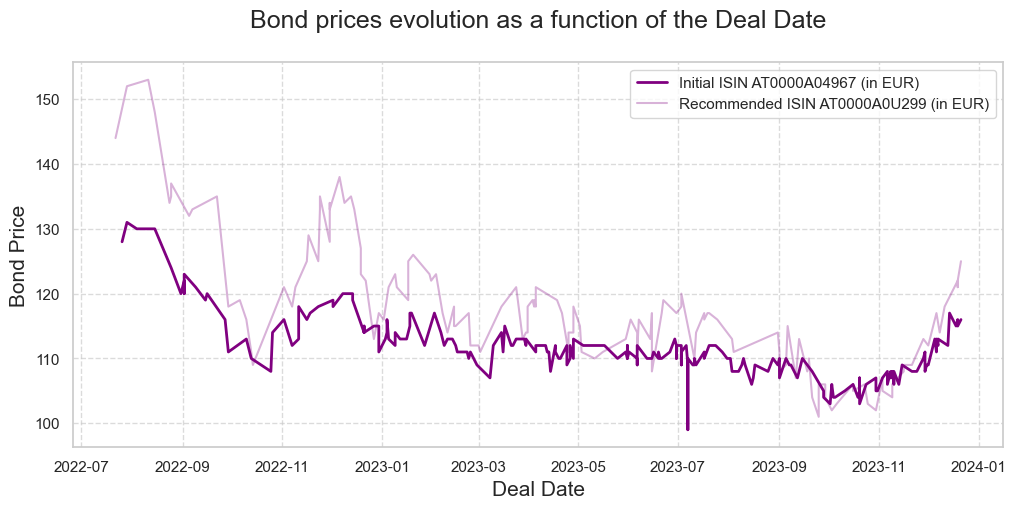

In [1561]:
def plot_double_price_evolution(df, ISIN1, ISIN2):
    """
    Plots the price evolution of a bond over its deal dates.

    Parameters:
    - df (DataFrame): The DataFrame containing bond data.
    - ISIN (str): The International Securities Identification Number of the bond.

    Returns:
    None
    """
    # Process the dataframe
    df_ISIN1 = df[df['ISIN'] == ISIN1].copy()
    df_ISIN1.sort_values(by='Deal_Date', inplace=True)

    df_ISIN2 = df[df['ISIN'] == ISIN2].copy()
    df_ISIN2.sort_values(by='Deal_Date', inplace=True)

    # Plot the figure with violet color scheme
    plt.figure(figsize=(12, 5))
    df_ISIN1_currency = df_ISIN1.iloc[0].Ccy
    df_ISIN2_currency = df_ISIN2.iloc[0].Ccy
    plt.plot(df_ISIN1['Deal_Date'], df_ISIN1['B_Price'], color='purple', linestyle='-', linewidth=2, label=f'Initial ISIN {ISIN1} (in {df_ISIN1_currency})')
    plt.plot(df_ISIN2['Deal_Date'], df_ISIN2['B_Price'], color='purple', alpha=0.3, linestyle='-', markersize=4, label=f'Recommended ISIN {ISIN2} (in {df_ISIN2_currency})')
    plt.xlabel('Deal Date', fontsize=15)
    plt.ylabel(f'Bond Price', fontsize=15)
    plt.title(f'Bond prices evolution as a function of the Deal Date\n', fontsize=18)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7) 
    plt.show()

# Example usage:
ISIN_ex1 = 'AT0000383864'
plot_double_price_evolution(df_preprocessed, ISIN_ex2, ISIN_ex4)

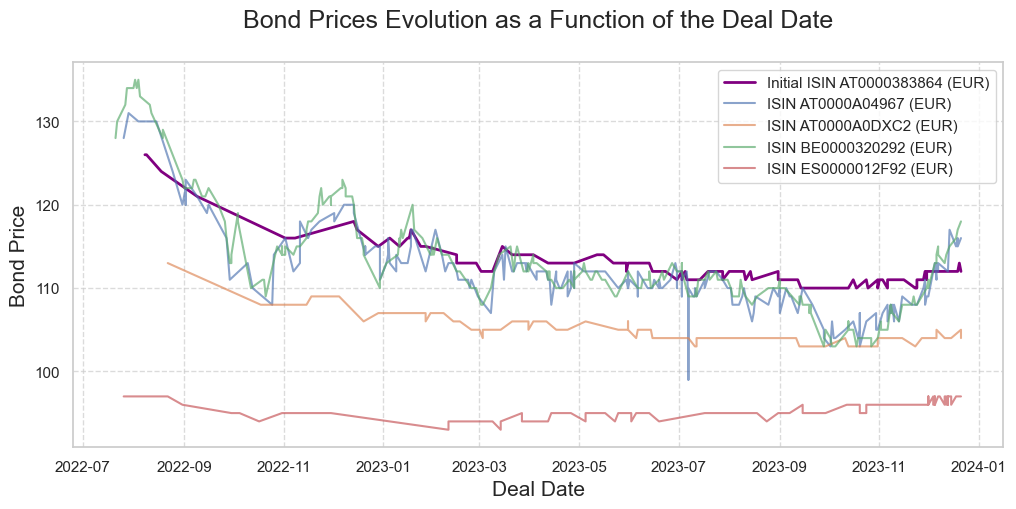

In [1562]:
def plot_double_price_evolution(df, initial_ISIN, df_similar_ISIN):
    """
    Plots the price evolution of bonds over their deal dates.

    Parameters:
    - df (DataFrame): The DataFrame containing bond data.
    - initial_ISIN (str): The International Securities Identification Number of the initial bond.
    - df_similar_ISIN (list): List of ISINs for similar bonds.

    Returns:
    None
    """
    # Filter DataFrame for initial ISIN
    df_initial_ISIN = df[df['ISIN'] == initial_ISIN].copy()
    df_initial_ISIN.sort_values(by='Deal_Date', inplace=True)

    # Check if the DataFrame is empty after filtering
    if df_initial_ISIN.empty:
        return f"No data found for the given initial ISIN: {initial_ISIN}."

    # Plot the figure with violet color scheme
    plt.figure(figsize=(12, 5))
    initial_currency = df_initial_ISIN.iloc[0].Ccy
    plt.plot(df_initial_ISIN['Deal_Date'], df_initial_ISIN['B_Price'], color='purple', linestyle='-', linewidth=2,
             label=f'Initial ISIN {initial_ISIN} ({initial_currency})')

    # Plot similar ISINs
    for similar_ISIN in df_similar_ISIN:
        # Filter DataFrame for similar ISIN
        df_similar_ISIN = df[df['ISIN'] == similar_ISIN].copy()
        df_similar_ISIN.sort_values(by='Deal_Date', inplace=True)

        # Check if the DataFrame is empty after filtering
        if df_similar_ISIN.empty:
            continue

        # Plot similar ISIN
        similar_currency = df_similar_ISIN.iloc[0].Ccy
        plt.plot(df_similar_ISIN['Deal_Date'], df_similar_ISIN['B_Price'], linestyle='-', alpha=0.65, markersize=4,
                 label=f'ISIN {similar_ISIN} ({similar_currency})')

    plt.xlabel('Deal Date', fontsize=15)
    plt.ylabel('Bond Price', fontsize=15)
    plt.title('Bond Prices Evolution as a Function of the Deal Date\n', fontsize=18)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
initial_ISIN = 'AT0000383864'
df_similar_ISIN = ['AT0000A04967', 'AT0000A0DXC2', 'BE0000320292', 'ES0000012F92']
plot_double_price_evolution(df_preprocessed, initial_ISIN, df_similar_ISIN)


C. Display of the grades comparision

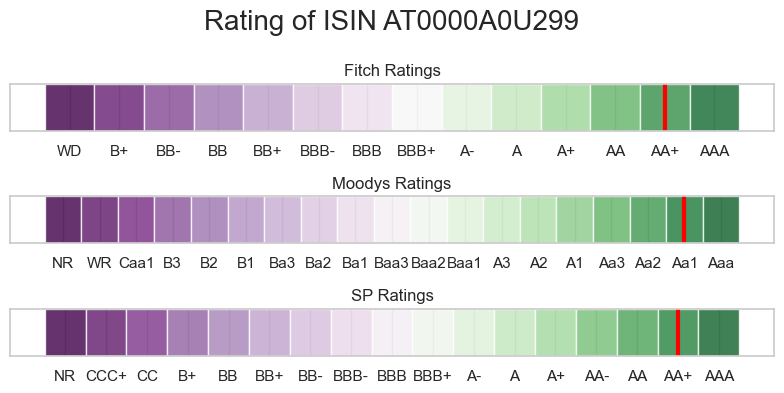

In [1563]:
def plot_triple_vertical_gauges(df, ISIN):
    # Dataframe for the specified ISIN
    df_ISIN = df[df['ISIN'] == ISIN]

    sorted_fitch_ratings = ['WD', 'B+', 'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+', 'AA', 'AA+', 'AAA']
    sorted_moodys_ratings = ['NR', 'WR', 'Caa1', 'B3', 'B2', 'B1', 'Ba3', 'Ba2', 'Ba1', 'Baa3', 'Baa2', 'Baa1', 'A3', 'A2', 'A1', 'Aa3', 'Aa2', 'Aa1', 'Aaa']
    sorted_sp_ratings = ['NR', 'CCC+', 'CC', 'B+', 'BB', 'BB+', 'BB-', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+', 'AA-', 'AA', 'AA+', 'AAA']

    # Create a figure and axes
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 4))

    # Plot for Fitch
    cmap_fitch = plt.get_cmap('PRGn')
    colors_fitch = [cmap_fitch(i / len(sorted_fitch_ratings)) for i in range(len(sorted_fitch_ratings))]
    grade_fitch = df_ISIN['Rating_Fitch'].iloc[0]

    for i, rating in enumerate(sorted_fitch_ratings):
        ax1.axvspan(i, i + 1, facecolor=colors_fitch[i], alpha=0.8)

    if grade_fitch and grade_fitch in sorted_fitch_ratings:
        grade_index_fitch = sorted_fitch_ratings.index(grade_fitch)
        ax1.axvline(x=grade_index_fitch + 0.5, color='red', linestyle='-', linewidth=3)

    ax1.set_xticks(np.arange(len(sorted_fitch_ratings)) + 0.5)
    ax1.set_xticklabels(sorted_fitch_ratings)
    ax1.set_yticks([])
    ax1.set_aspect('auto')
    ax1.set_title(f'Fitch Ratings')

    # Plot for Moodys
    cmap_moodys = plt.get_cmap('PRGn')
    colors_moodys = [cmap_moodys(i / len(sorted_moodys_ratings)) for i in range(len(sorted_moodys_ratings))]
    grade_moodys = df_ISIN['Rating_Moodys'].iloc(0)

    for i, rating in enumerate(sorted_moodys_ratings):
        ax2.axvspan(i, i + 1, facecolor=colors_moodys[i], alpha=0.8)

    if grade_moodys and grade_moodys[0] in sorted_moodys_ratings:
        grade_index_moodys = sorted_moodys_ratings.index(grade_moodys[0])
        ax2.axvline(x=grade_index_moodys + 0.5, color='red', linestyle='-', linewidth=3)

    ax2.set_xticks(np.arange(len(sorted_moodys_ratings)) + 0.5)
    ax2.set_xticklabels(sorted_moodys_ratings)
    ax2.set_yticks([])
    ax2.set_aspect('auto')
    ax2.set_title(f'Moodys Ratings')

    # Plot for SP
    cmap_sp = plt.get_cmap('PRGn')
    colors_sp = [cmap_sp(i / len(sorted_sp_ratings)) for i in range(len(sorted_sp_ratings))]
    grade_sp = df_ISIN['Rating_SP'].iloc[0]

    for i, rating in enumerate(sorted_sp_ratings):
        ax3.axvspan(i, i + 1, facecolor=colors_sp[i], alpha=0.8)

    if grade_sp and grade_sp in sorted_sp_ratings:
        grade_index_sp = sorted_sp_ratings.index(grade_sp)
        ax3.axvline(x=grade_index_sp + 0.5, color='red', linestyle='-', linewidth=3)

    ax3.set_xticks(np.arange(len(sorted_sp_ratings)) + 0.5)
    ax3.set_xticklabels(sorted_sp_ratings)
    ax3.set_yticks([])
    ax3.set_aspect('auto')
    ax3.set_title(f'SP Ratings')

    plt.suptitle(f'Rating of ISIN {ISIN}', fontsize=20)

    plt.tight_layout()
    plt.show()

# Run
plot_triple_vertical_gauges(df_preprocessed, ISIN_ex4)


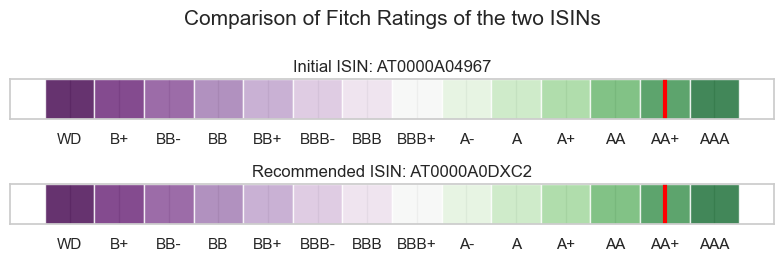

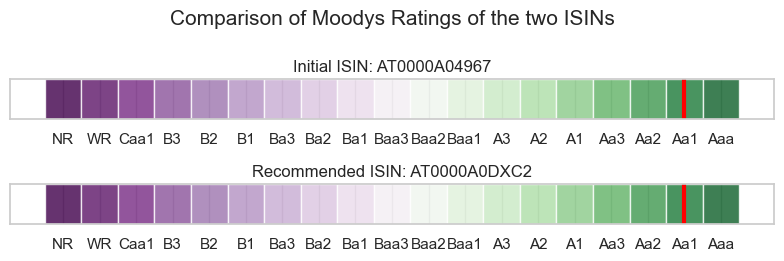

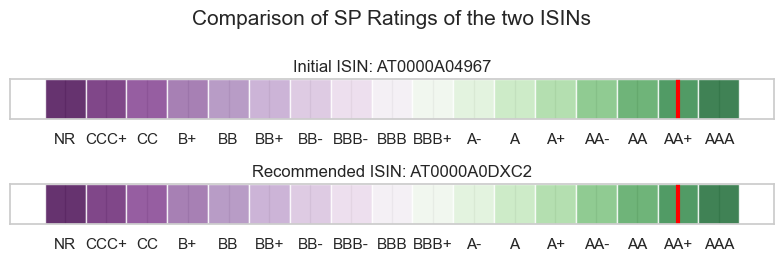

In [1564]:
def plot_double_horizontal_gauges(df, ISIN1, ISIN2, rating_name='Fitch'):

    # Dataframes for both ISINs
    df_ISIN1 = df[df['ISIN'] == ISIN1]
    df_ISIN2 = df[df['ISIN'] == ISIN2]

    if rating_name == 'Fitch':
        sorted_ratings = ['WD', 'B+', 'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+', 'AA', 'AA+', 'AAA']
        grade1 = df_ISIN1.Rating_Fitch.iloc[0]
        grade2 = df_ISIN2.Rating_Fitch.iloc[0]

    if rating_name == 'Moodys':
        sorted_ratings = ['NR', 'WR', 'Caa1', 'B3', 'B2', 'B1', 'Ba3', 'Ba2', 'Ba1', 'Baa3', 'Baa2', 'Baa1', 'A3', 'A2', 'A1', 'Aa3', 'Aa2', 'Aa1', 'Aaa']
        grade1 = df_ISIN1.Rating_Moodys.iloc[0]
        grade2 = df_ISIN2.Rating_Moodys.iloc[0]

    if rating_name == 'SP':
        sorted_ratings = ['NR', 'CCC+', 'CC', 'B+', 'BB', 'BB+', 'BB-', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+', 'AA-', 'AA', 'AA+', 'AAA']
        grade1 = df_ISIN1.Rating_SP.iloc[0]
        grade2 = df_ISIN2.Rating_SP.iloc[0]

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 2.65))

    # Plot for ISIN1
    cmap = plt.get_cmap('PRGn')  # Modified colormap for red to green gradient
    colors1 = [cmap(i / len(sorted_ratings)) for i in range(len(sorted_ratings))]
    for i, rating in enumerate(sorted_ratings):
        ax1.axvspan(i, i + 1, facecolor=colors1[i], alpha=0.8)

    if grade1 and grade1 in sorted_ratings:
        grade_index1 = sorted_ratings.index(grade1)
        ax1.axvline(x=grade_index1 + 0.5, color='red', linestyle='-', linewidth=3)

    ax1.set_xticks(np.arange(len(sorted_ratings)) + 0.5)
    ax1.set_xticklabels(sorted_ratings)
    ax1.set_yticks([])
    ax1.set_aspect('auto')
    ax1.set_title(f'Initial ISIN: {ISIN1}')

    # Plot for ISIN2
    colors2 = [cmap(i / len(sorted_ratings)) for i in range(len(sorted_ratings))]
    for i, rating in enumerate(sorted_ratings):
        ax2.axvspan(i, i + 1, facecolor=colors2[i], alpha=0.8)

    if grade2 and grade2 in sorted_ratings:
        grade_index2 = sorted_ratings.index(grade2)
        ax2.axvline(x=grade_index2 + 0.5, color='red', linestyle='-', linewidth=3)

    ax2.set_xticks(np.arange(len(sorted_ratings)) + 0.5)
    ax2.set_xticklabels(sorted_ratings)
    ax2.set_yticks([])
    ax2.set_aspect('auto')
    ax2.set_title(f'Recommended ISIN: {ISIN2}')
    plt.suptitle(f'Comparison of {rating_name} Ratings of the two ISINs', fontsize=15)
    plt.tight_layout()
    plt.show()

# Run
plot_double_horizontal_gauges(df_preprocessed, ISIN_ex2, ISIN_ex3, rating_name='Fitch')
plot_double_horizontal_gauges(df_preprocessed, ISIN_ex2, ISIN_ex3, rating_name='Moodys')
plot_double_horizontal_gauges(df_preprocessed, ISIN_ex2, ISIN_ex3, rating_name='SP')


E. Display the clients repartition 

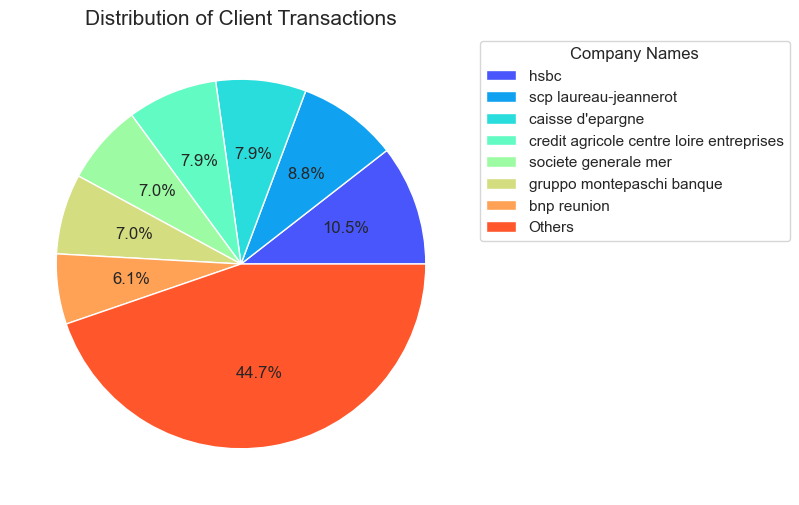

In [1566]:
def plot_clients_repartition(df_preprocessed, ISIN_ex1):

    # Generate the dataframe
    df_ISIN = df_preprocessed[df_preprocessed['ISIN'] == ISIN_ex1].copy()
    clien_unique_count = df_ISIN['company_short_name'].value_counts()
    client_count_df = pd.DataFrame(clien_unique_count.reset_index())
    total_count = client_count_df['count'].sum()
    client_count_df['count_perc'] = np.round(client_count_df['count'] * 100 / total_count, 2)
    client_count_df.drop(columns = ['count'], inplace=True)
    df_client_other = client_count_df[client_count_df['count_perc'] < 6].copy()
    client_count_df = client_count_df[client_count_df['count_perc'] >= 6].copy()
    count_perc_other = np.round(df_client_other.count_perc.sum(), 2)

    # Add the 'Other' line to the DataFrame
    line_to_add = pd.DataFrame({'company_short_name': ['Others'], 'count_perc': [count_perc_other]})
    client_count_df = pd.concat([client_count_df, line_to_add], ignore_index=True, axis=0)

    # Plotting a pie chart using the rainbow colormap
    plt.figure(figsize=(8, 6))
    colors = sns.color_palette("rainbow", len(client_count_df))
    plt.pie(client_count_df['count_perc'], autopct='%1.1f%%', colors=colors)
    plt.title('Distribution of Client Transactions', fontsize=15)

    # Add legend at the top right
    plt.legend(client_count_df['company_short_name'], bbox_to_anchor=(1, 1), loc='upper left', title='Company Names')

    plt.show()

plot_clients_repartition(df_preprocessed, ISIN_ex1)

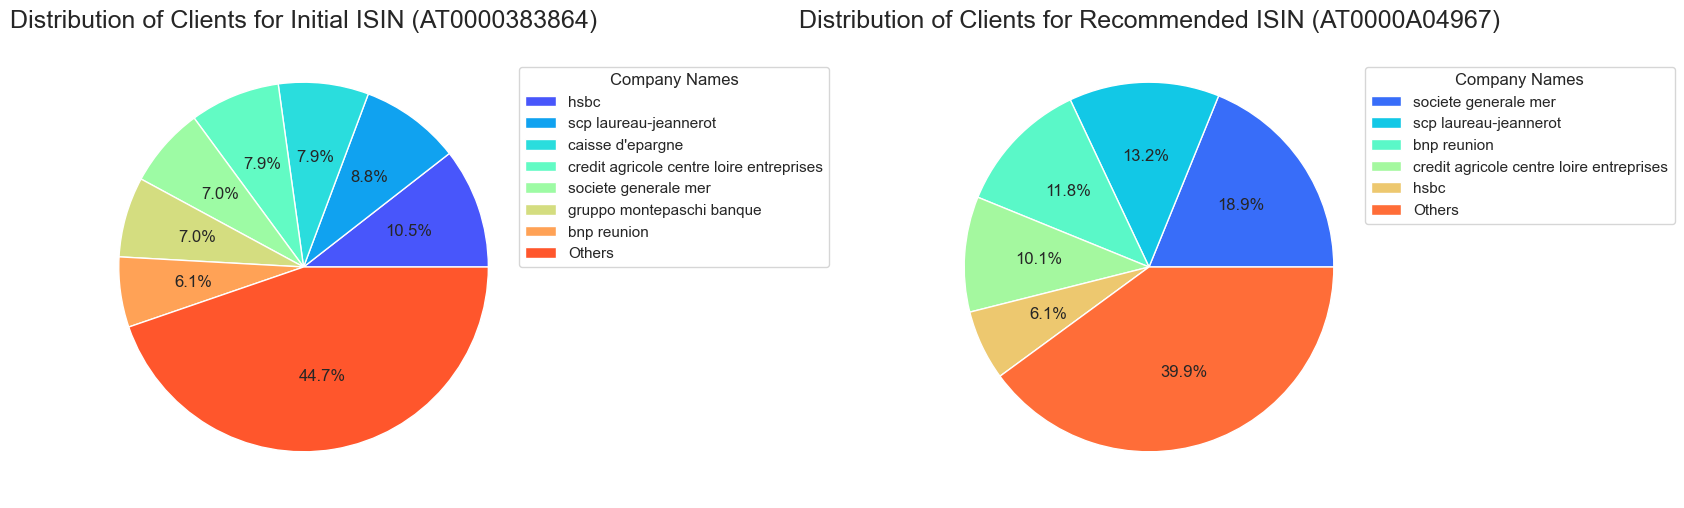

In [1573]:
def plot_double_clients_repartition(df_preprocessed, ISIN_ex1, ISIN_ex2):
    # Generate the dataframe for ISIN_ex1
    df_ISIN1 = df_preprocessed[df_preprocessed['ISIN'] == ISIN_ex1].copy()
    clien_unique_count1 = df_ISIN1['company_short_name'].value_counts()
    client_count_df1 = pd.DataFrame(clien_unique_count1.reset_index())
    total_count1 = client_count_df1['count'].sum()
    client_count_df1['count_perc'] = np.round(client_count_df1['count'] * 100 / total_count1, 2)
    client_count_df1.drop(columns=['count'], inplace=True)
    df_client_other1 = client_count_df1[client_count_df1['count_perc'] < 6].copy()
    client_count_df1 = client_count_df1[client_count_df1['count_perc'] >= 6].copy()
    count_perc_other1 = np.round(df_client_other1.count_perc.sum(), 2)

    # Add the 'Other' line to the DataFrame for ISIN_ex1
    line_to_add1 = pd.DataFrame({'company_short_name': ['Others'], 'count_perc': [count_perc_other1]})
    client_count_df1 = pd.concat([client_count_df1, line_to_add1], ignore_index=True, axis=0)

    # Generate the dataframe for ISIN_ex2
    df_ISIN2 = df_preprocessed[df_preprocessed['ISIN'] == ISIN_ex2].copy()
    clien_unique_count2 = df_ISIN2['company_short_name'].value_counts()
    client_count_df2 = pd.DataFrame(clien_unique_count2.reset_index())
    total_count2 = client_count_df2['count'].sum()
    client_count_df2['count_perc'] = np.round(client_count_df2['count'] * 100 / total_count2, 2)
    client_count_df2.drop(columns=['count'], inplace=True)
    df_client_other2 = client_count_df2[client_count_df2['count_perc'] < 6].copy()
    client_count_df2 = client_count_df2[client_count_df2['count_perc'] >= 6].copy()
    count_perc_other2 = np.round(df_client_other2.count_perc.sum(), 2)

    # Add the 'Other' line to the DataFrame for ISIN_ex2
    line_to_add2 = pd.DataFrame({'company_short_name': ['Others'], 'count_perc': [count_perc_other2]})
    client_count_df2 = pd.concat([client_count_df2, line_to_add2], ignore_index=True, axis=0)

    # Plotting pie charts side by side
    plt.figure(figsize=(20, 6))

    # Plot for ISIN_ex1
    plt.subplot(1, 2, 1)
    colors1 = sns.color_palette("rainbow", len(client_count_df1))
    plt.pie(client_count_df1['count_perc'], autopct='%1.1f%%', colors=colors1)
    plt.title(f'Distribution of Clients for Initial ISIN ({ISIN_ex1})', fontsize=18)
    plt.legend(client_count_df1['company_short_name'], bbox_to_anchor=(0.95, 0.95), 
               loc='upper left', title='Company Names')

    # Plot for ISIN_ex2
    plt.subplot(1, 2, 2)
    colors2 = sns.color_palette("rainbow", len(client_count_df2))
    plt.pie(client_count_df2['count_perc'], autopct='%1.1f%%', colors=colors2)
    plt.title(f'Distribution of Clients for Recommended ISIN ({ISIN_ex2})', fontsize=18)
    plt.legend(client_count_df2['company_short_name'], bbox_to_anchor=(0.95, 0.95), 
               loc='upper left', title='Company Names')

    plt.show()

# Example usage:
plot_double_clients_repartition(df_preprocessed, ISIN_ex1, ISIN_ex2)


F. Other numerical values display as a function of the deal date

In [1567]:
def plot_double_GSpreadMid_evolution(df, ISIN1, ISIN2, column='MidYTM'):
    """
    Plots the evolution of the 'column' value of a bond over its deal dates.

    Parameters:
    - df (DataFrame): The DataFrame containing bond data.
    - ISIN (str): The International Securities Identification Number of the bond.

    Returns:
    None
    """
    # Process the dataframe
    df_ISIN1 = df[df['ISIN'] == ISIN1].copy()
    df_ISIN1.sort_values(by='Deal_Date', inplace=True)

    df_ISIN2 = df[df['ISIN'] == ISIN2].copy()
    df_ISIN2.sort_values(by='Deal_Date', inplace=True)

    # Plot the figure with violet color scheme
    plt.figure(figsize=(8, 3))
    plt.plot(df_ISIN1['Deal_Date'], df_ISIN1[column], color='purple', linestyle='-', linewidth=2, label=f'Initial ISIN {ISIN1}')
    plt.plot(df_ISIN2['Deal_Date'], df_ISIN2[column], color='purple', alpha=0.3, linestyle='-', markersize=4, label=f'Recommended ISIN {ISIN2}')
    plt.xlabel('Deal Date', fontsize=12)
    plt.ylabel(f'{column}', fontsize=12)
    plt.title(f'{column} as a function of the Deal Date\n', fontsize=18)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7) 
    plt.show()

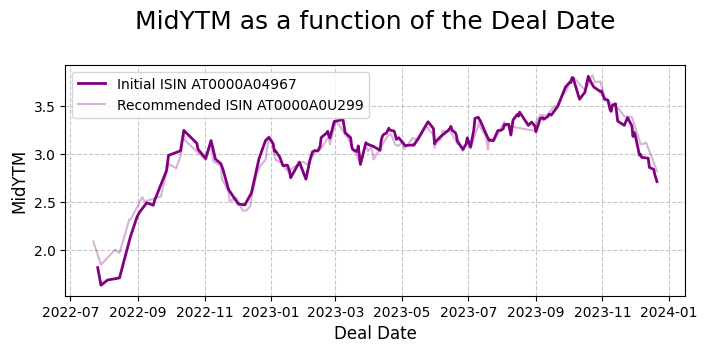

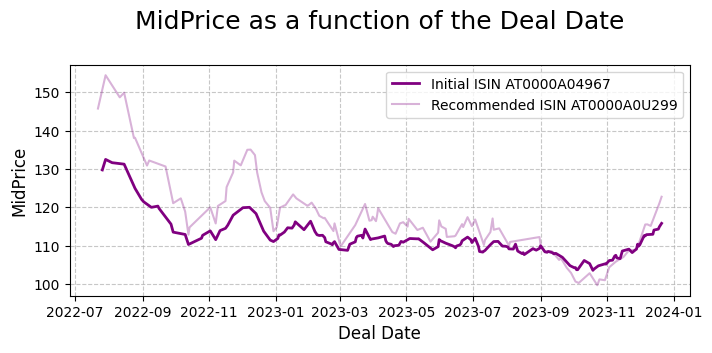

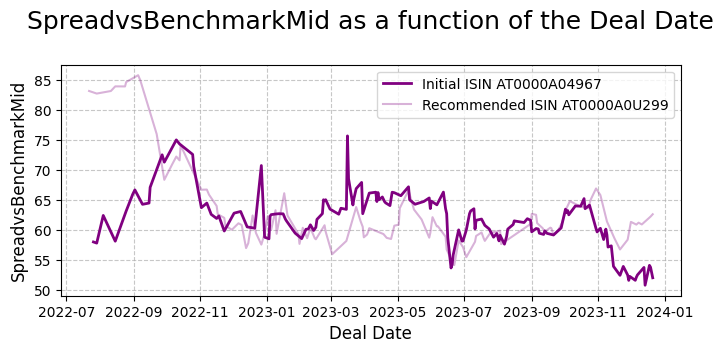

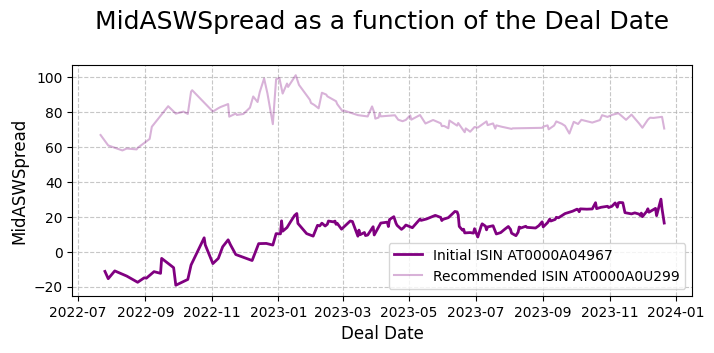

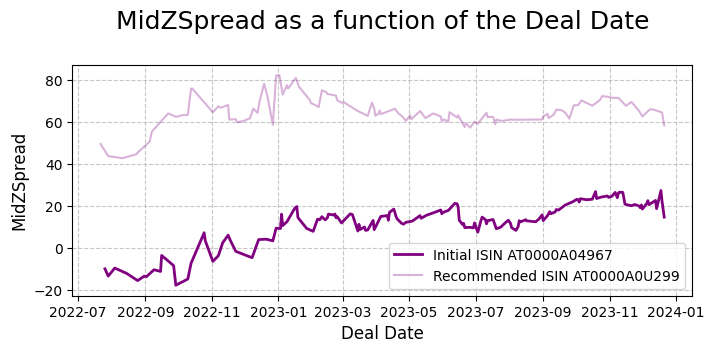

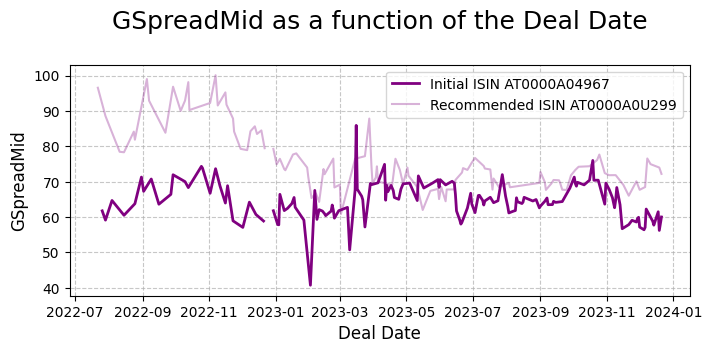

In [1219]:
# Run this function
columns_to_compare = ['MidYTM', 'MidPrice', 'SpreadvsBenchmarkMid', 'MidASWSpread',
                      'MidZSpread', 'GSpreadMid']

for feature in columns_to_compare :
    plot_double_GSpreadMid_evolution(df_preprocessed, ISIN_ex2, ISIN_ex4, column=feature) 

In [1575]:
df_preprocessed.Total_Traded_Volume

6           13061.0
7             136.0
8         1224490.0
9           91837.0
12           2041.0
            ...    
635424      24082.0
635426      20408.0
635431      40816.0
635435     214286.0
635451      40816.0
Name: Total_Traded_Volume, Length: 314678, dtype: float64

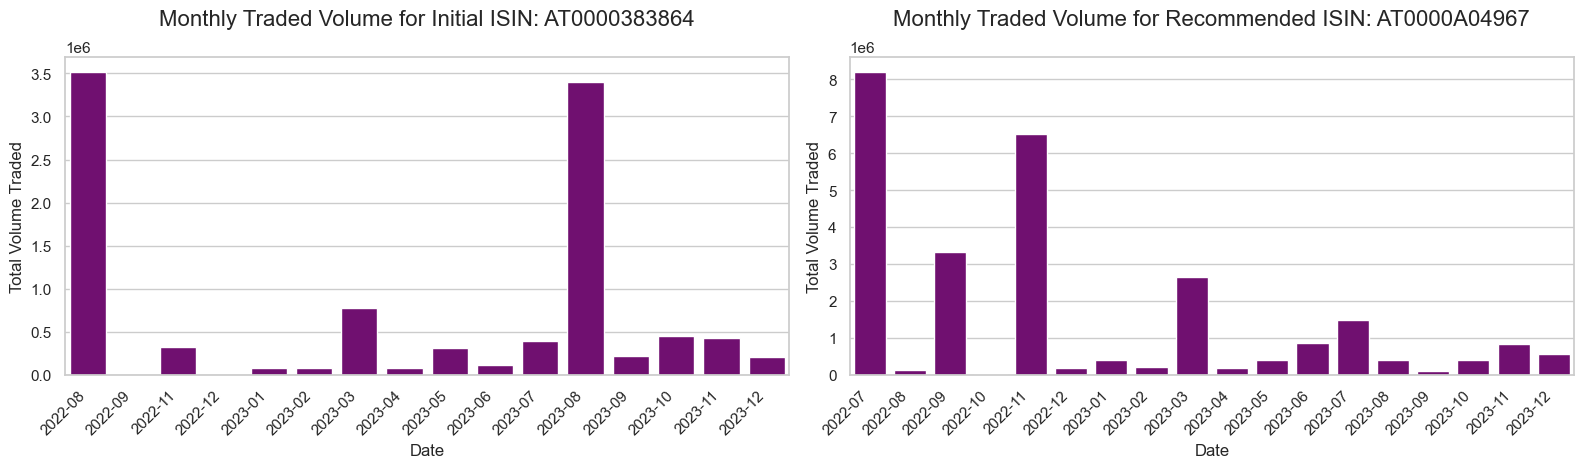

In [1623]:
def plot_monthly_traded_volume(df, ISIN1, ISIN2):
    """
    Plots the monthly traded volume for two given ISINs side by side.

    Parameters:
    - df (DataFrame): The DataFrame containing bond data.
    - ISIN1 (str): The International Securities Identification Number of the first bond.
    - ISIN2 (str): The International Securities Identification Number of the second bond.

    Returns:
    None
    """
    # Process the dataframe for ISIN1
    df_ISIN1 = df[df['ISIN'] == ISIN1].copy()
    df_ISIN1['Deal_Date'] = pd.to_datetime(df_ISIN1['Deal_Date'])
    df_ISIN1['Date'] = df_ISIN1['Deal_Date'].dt.to_period('M')
    df_ISIN1 = df_ISIN1.groupby('Date')['Total_Traded_Volume'].sum().reset_index()

    # Process the dataframe for ISIN2
    df_ISIN2 = df[df['ISIN'] == ISIN2].copy()
    df_ISIN2['Deal_Date'] = pd.to_datetime(df_ISIN2['Deal_Date'])
    df_ISIN2['Date'] = df_ISIN2['Deal_Date'].dt.to_period('M')
    df_ISIN2 = df_ISIN2.groupby('Date')['Total_Traded_Volume'].sum().reset_index()

    # Plot side by side
    plt.figure(figsize=(16, 5))

    # Plot for ISIN1
    plt.subplot(1, 2, 1)
    ax1 = sns.barplot(x='Date', y='Total_Traded_Volume', data=df_ISIN1, color='purple')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Monthly Traded Volume for Initial ISIN: {ISIN1}\n', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Total Volume Traded')

    # Plot for ISIN2
    plt.subplot(1, 2, 2)
    ax2 = sns.barplot(x='Date', y='Total_Traded_Volume', data=df_ISIN2, color='purple')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Monthly Traded Volume for Recommended ISIN: {ISIN2}\n', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Total Volume Traded')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_monthly_traded_volume(df_preprocessed, ISIN_ex1, ISIN_ex2)

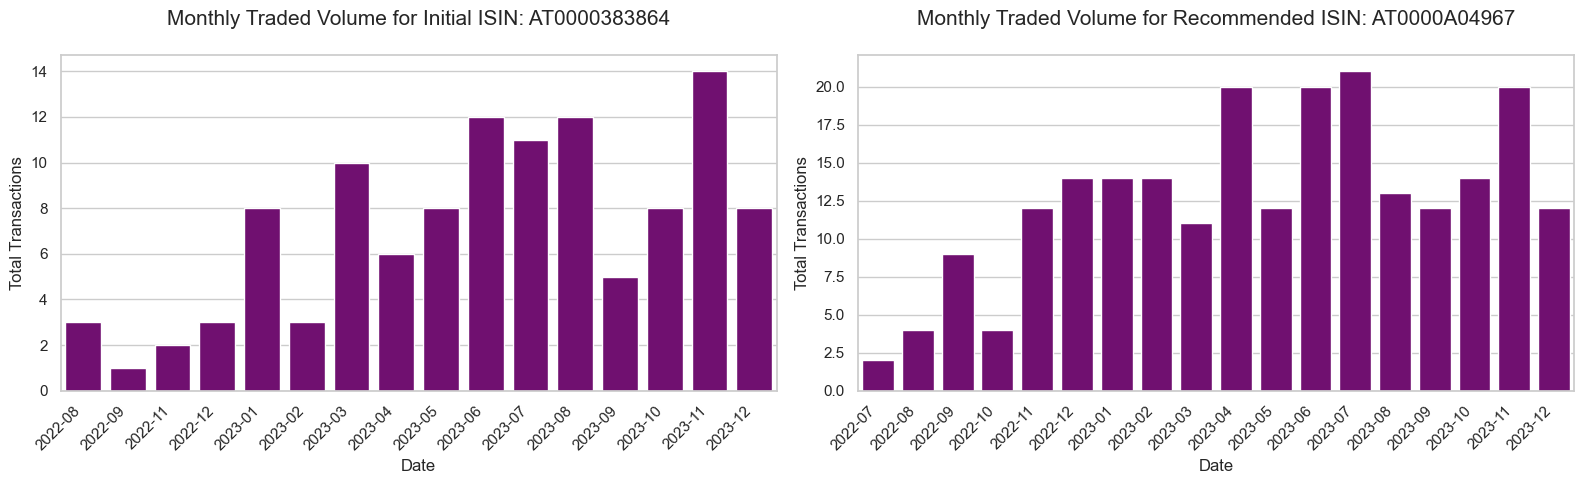

In [1630]:
def plot_monthly_traded_volume(df, ISIN1, ISIN2):
    """
    Plots the monthly traded volume for two given ISINs side by side.

    Parameters:
    - df (DataFrame): The DataFrame containing bond data.
    - ISIN1 (str): The International Securities Identification Number of the first bond.
    - ISIN2 (str): The International Securities Identification Number of the second bond.

    Returns:
    None
    """
    # Process the dataframe for ISIN1
    df_ISIN1 = df[df['ISIN'] == ISIN1].copy()
    df_ISIN1['Deal_Date'] = pd.to_datetime(df_ISIN1['Deal_Date'])
    df_ISIN1['Date'] = df_ISIN1['Deal_Date'].dt.to_period('M')
    df_ISIN1['transaction'] = 1
    df_ISIN1 = df_ISIN1.groupby('Date')['transaction'].sum().reset_index()

    # Process the dataframe for ISIN2
    df_ISIN2 = df[df['ISIN'] == ISIN2].copy()
    df_ISIN2['Deal_Date'] = pd.to_datetime(df_ISIN2['Deal_Date'])
    df_ISIN2['Date'] = df_ISIN2['Deal_Date'].dt.to_period('M')
    df_ISIN2['transaction'] = 1
    df_ISIN2 = df_ISIN2.groupby('Date')['transaction'].sum().reset_index()

    # Plot side by side
    plt.figure(figsize=(16, 5))

    # Plot for ISIN1
    plt.subplot(1, 2, 1)
    ax1 = sns.barplot(x='Date', y='transaction', data=df_ISIN1, color='purple')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Monthly Traded Volume for Initial ISIN: {ISIN1}\n', fontsize=15)
    plt.xlabel('Date')
    plt.ylabel('Total Transactions')

    # Plot for ISIN2
    plt.subplot(1, 2, 2)
    ax2 = sns.barplot(x='Date', y='transaction', data=df_ISIN2, color='purple')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Monthly Traded Volume for Recommended ISIN: {ISIN2}\n', fontsize=15)
    plt.xlabel('Date')
    plt.ylabel('Total Transactions')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_monthly_traded_volume(df_preprocessed, ISIN_ex1, ISIN_ex2)